# Libraries

In [1]:
# Essential Libraries for Data Manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import itertools

# Data Fetching and File Handling
import requests
import os
import gzip
import shutil
import time

# Data Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Preprocessing and Metrics
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Deep Learning with Keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Hyperparameter Optimization with Optuna
import optuna
from optuna.integration import KerasPruningCallback
import optuna.visualization as ov

# Time Series Analysis with Statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# PySpark for Large-Scale Data Processing
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, trim, when, isnan, count, mean, last, first, year
from pyspark.sql.window import Window
from functools import reduce
from operator import or_

# IPython Utilities for Interactive Notebooks
from IPython.display import FileLink

# Serialization and Model Persistence
import joblib
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from functools import reduce
from pyspark.sql import functions as F

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# INDEX,Rates and Technical Indicators

## INDEX Indicator

## Technical Indicators

## Technical Indicator Analysis Commentary

In the analysis of the EURO STOXX 50 index, It has been identified that the Financial Modeling Prep (FMP) API was not feasible for extracting technical indicators such as SMA, EMA, and MACD (5+ Year Historical Data). This led to the implementation of an alternative approach using the pandas library in Python.

The methodology adhered to established financial analysis standards and utilized conventional computational techniques for the calculation of these indicators. The Simple Moving Average (SMA) and the Exponential Moving Average (EMA) were computed over a 50-day period. Additionally, the Moving Average Convergence Divergence (MACD) was calculated. Initially, the MACD's three components - the MACD line, the Signal line, and the MACD Histogram - were considered. However, the analysis was later refined to include only the MACD line to maintain focus and relevance.

Utilizing pandas for this purpose offered enhanced flexibility and control in data manipulation and calculations. This approach ensured that the analysis was not constrained by the limitations of external data sources or APIs. The resulting dataset, which begins from January 4, 2005, provides a detailed view of the index's performance with accurately computed SMA, EMA, and MACD values, facilitating a thorough technical analysis.

In [3]:
# Path to the CSV file on the desktop
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')  # Path to the desktop
file_path = os.path.join(desktop_path, 'STOXX50E.csv')  # File Name

# Load the dataset from the CSV file
index_df = pd.read_csv(file_path)

# Filter to only use 'date' and 'close' columns
index_df = index_df[['date', 'close']]

# Rename columns to 'Date' and 'Close'
index_df.rename(columns={'date': 'Date', 'close': 'Close'}, inplace=True)

# Convert 'Date' to datetime
index_df['Date'] = pd.to_datetime(index_df['Date'])

# Calculate the 50-day Simple Moving Average (SMA)
index_df['SMA'] = index_df['Close'].rolling(window=50, min_periods=1).mean()

# Calculate the 50-day Exponential Moving Average (EMA)
index_df['EMA'] = index_df['Close'].ewm(span=50, adjust=False).mean()

# Calculate only the MACD Line (12-day EMA - 26-day EMA)
index_df['MACD'] = index_df['Close'].ewm(span=12, adjust=False).mean() - index_df['Close'].ewm(span=26, adjust=False).mean()

# Filter the DataFrame for dates after 2006-01-02
index_data = index_df[index_df['Date'] >= pd.to_datetime('2006-01-02')]

# Convert 'Date' from datetime to date (to remove time component)
index_data['Date'] = index_data['Date'].dt.date

# Now, use describe() on the filtered DataFrame for the numerical columns
descriptive_stats = index_data[['Close', 'SMA', 'EMA', 'MACD']].describe()

# Print the descriptive statistics
print(descriptive_stats)

             Close          SMA          EMA         MACD
count  4580.000000  4580.000000  4580.000000  4580.000000
mean   3331.470597  3336.877300  3337.253795    -1.682844
std     608.188973   605.063876   601.451103    43.794864
min    1809.979981  2091.644585  2096.246724  -140.620963
25%    2880.682495  2880.461552  2874.442989   -28.815001
50%    3338.089966  3333.819001  3329.223542    -6.095822
75%    3740.507524  3726.657101  3703.855823    19.642689
max    4763.850100  4763.850100  4763.850100   275.182951


In [4]:
index_data.describe()

,Close,SMA,EMA,MACD
count,4580.000000,4580.000000,4580.000000,4580.000000
mean,3331.470597,3336.877300,3337.253795,-1.682844
std,608.188973,605.063876,601.451103,43.794864
min,1809.979981,2091.644585,2096.246724,-140.620963
25%,2880.682495,2880.461552,2874.442989,-28.815001
50%,3338.089966,3333.819001,3329.223542,-6.095822
75%,3740.507524,3726.657101,3703.855823,19.642689
max,4763.850100,4763.850100,4763.850100,275.182951


In [5]:
index_data.head()

,Date,Close,SMA,EMA,MACD
0,2024-02-16,4763.85010,4763.850100,4763.850100,0.000000
1,2024-02-15,4743.16992,4753.510010,4763.039113,-1.649701
2,2024-02-14,4709.22021,4738.746743,4760.928567,-5.631641
3,2024-02-13,4689.27979,4726.380005,4758.118811,-10.277905
4,2024-02-12,4746.35010,4730.374024,4757.657293,-9.248395


## Interest Rate API (Eurostat)

In [6]:
# Dataset code
dataset_code = "ei_mfir_m"

# API URL for downloading the dataset
api_url = f"https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/{dataset_code}?format=TSV&compressed=true"

# Download the dataset
response = requests.get(api_url, stream=True)
output_file = dataset_code + ".tsv.gz"

if response.status_code == 200:
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print(f"Error downloading dataset. Status code: {response.status_code}")

# Unzipping the dataset
with gzip.open(output_file, 'rb') as f_in:
    with open(dataset_code + ".tsv", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Dataset unzipped successfully.")

Dataset downloaded successfully.
Dataset unzipped successfully.


In [7]:
# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

# Construct the file path dynamically
file_name = 'ei_mfir_m.tsv'  # File Name
file_path = os.path.join(current_directory, file_name)

# Load the dataset
data = pd.read_csv(file_path, sep='\t')

# Split the first column into separate columns
split_columns = data.iloc[:, 0].str.split(',', expand=True)
split_columns.columns = ['freq', 's_adj', 'p_adj', 'indic', 'geo']

# Combine the split columns with the original data (excluding the first column)
structured_data = pd.concat([split_columns, data.iloc[:, 1:]], axis=1)

# Apply filters
structured_data = structured_data[
    (structured_data['indic'] == 'MF-3MI-RT')
]

# Drop unnecessary columns
structured_data.drop(['freq', 's_adj', 'p_adj'], axis=1, inplace=True)

# Filter for date range (from Jan, 2005, onwards)
date_columns = structured_data.columns[3:]
dates_from_2006 = date_columns[date_columns >= '2005-01 ']
structured_data = structured_data[['indic','geo'] + list(dates_from_2006)]

# Reset the index for a clean table
structured_data.reset_index(drop=True, inplace=True)

# Display the structured DataFrame
pd.set_option('display.max_columns', None)

Current Working Directory: /home/fabiopoli/Desktop


In [8]:
# Ensure that the date columns include '2005-01'
date_columns = structured_data.columns[4:]  # Starting from the 5th column
data_for_melting = structured_data[['geo'] + list(date_columns)]

# Melting the DataFrame
melted_data = pd.melt(data_for_melting, id_vars=['geo'], var_name='Period', value_name='Interest')

# Ensure 'Period' is of datetime type
melted_data['Period'] = pd.to_datetime(melted_data['Period'])

# Filter for 'geo' == 'EA'
Interest_data_ea = melted_data[melted_data['geo'] == 'EA']

# Apply forward filling
Interest_data_ea = Interest_data_ea.sort_values('Period')
Interest_data_ea['Interest'] = Interest_data_ea['Interest'].ffill()

# Reset index for a clean DataFrame
Interest_data_ea.reset_index(drop=True, inplace=True)

# Display the transformed DataFrame
print(Interest_data_ea.head(10))

  geo     Period  Interest
0  EA 2005-03-01  2.13720 
1  EA 2005-04-01  2.13720 
2  EA 2005-05-01  2.12560 
3  EA 2005-06-01  2.11100 
4  EA 2005-07-01  2.11940 
5  EA 2005-08-01  2.13250 
6  EA 2005-09-01  2.13910 
7  EA 2005-10-01  2.19660 
8  EA 2005-11-01  2.36090 
9  EA 2005-12-01  2.47290 


##### Forward Filling

In [9]:
# Convert 'Period' to datetime
Interest_data_ea['Period'] = pd.to_datetime(Interest_data_ea['Period'])

# Set 'Period' as the index
Interest_data_ea.set_index('Period', inplace=True)

# Create a daily date range that covers the entire period in your data
start_date = Interest_data_ea.index.min()
end_date = Interest_data_ea.index.max()
all_days = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex the DataFrame to this date range, forward filling the missing values
daily_interest_data = Interest_data_ea.reindex(all_days).ffill()

# Reset the index so 'Period' becomes a column again
daily_interest_data.reset_index(inplace=True)
daily_interest_data.rename(columns={'index': 'Period'}, inplace=True)

# Filter for dates starting from January 2, 2006
daily_interest_data = daily_interest_data[daily_interest_data['Period'] >= '2006-01-02']

# Exclude weekends (Saturday and Sunday)
daily_interest_data = daily_interest_data[~daily_interest_data['Period'].dt.dayofweek.isin([5, 6])]

# Display the first 10 rows of the daily data
print(daily_interest_data.head(10))

        Period geo  Interest
307 2006-01-02  EA  2.51170 
308 2006-01-03  EA  2.51170 
309 2006-01-04  EA  2.51170 
310 2006-01-05  EA  2.51170 
311 2006-01-06  EA  2.51170 
314 2006-01-09  EA  2.51170 
315 2006-01-10  EA  2.51170 
316 2006-01-11  EA  2.51170 
317 2006-01-12  EA  2.51170 
318 2006-01-13  EA  2.51170 


##### KNN Filling

In [10]:
# Check if 'Period' is in the columns; if not, the index might already be the 'Period'
if 'Period' in Interest_data_ea.columns:
    Interest_data_ea['Period'] = pd.to_datetime(Interest_data_ea['Period'])
    Interest_data_ea.set_index('Period', inplace=True)
elif not isinstance(Interest_data_ea.index, pd.DatetimeIndex):
    # If the index is not a datetime, convert it
    Interest_data_ea.index = pd.to_datetime(Interest_data_ea.index)

# Create a daily date range
start_date = Interest_data_ea.index.min()
end_date = Interest_data_ea.index.max()
all_days = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex to create a DataFrame with all days, introducing NaNs for days without data
interest_data = Interest_data_ea.reindex(all_days)

# Convert the index to a numerical value for KNN
interest_data['Day_Ordinal'] = interest_data.index.map(datetime.toordinal)

# Extract the 'Interest' column for imputation
knn_data = interest_data[['Day_Ordinal', 'Interest']].values

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation
knn_data_imputed = knn_imputer.fit_transform(knn_data)

# Put the imputed 'Interest' data back into the DataFrame
interest_data['Interest'] = knn_data_imputed[:, 1]

# Drop the 'Day_Ordinal' column as it's no longer needed
interest_data.drop('Day_Ordinal', axis=1, inplace=True)

# Reset index to make 'Period' a column again
interest_data.reset_index(inplace=True)
interest_data.rename(columns={'index': 'Period'}, inplace=True)

# If the 'geo' column is required, fill it with a constant value (e.g., 'EA')
interest_data['geo'] = 'EA'

# Filter for dates starting from January 2, 2006
interest_data = interest_data[interest_data['Period'] >= '2006-01-02']

# Exclude weekends (Saturday and Sunday)
interest_data = interest_data[~interest_data['Period'].dt.dayofweek.isin([5, 6])]


# Display the first 10 rows of the daily data
print(interest_data.head(10))

        Period geo  Interest
307 2006-01-02  EA    2.5337
308 2006-01-03  EA    2.5337
309 2006-01-04  EA    2.5337
310 2006-01-05  EA    2.5337
311 2006-01-06  EA    2.5337
314 2006-01-09  EA    2.5337
315 2006-01-10  EA    2.5337
316 2006-01-11  EA    2.5337
317 2006-01-12  EA    2.5337
318 2006-01-13  EA    2.5337


In [11]:
# Check for null values
null_counts = interest_data.isnull().sum()
print("Null Values in Each Column:\n", null_counts)

# Check for NaN values
nan_counts = interest_data.isna().sum()
print("\nNaN Values in Each Column:\n", nan_counts)

# Check for zero values
zero_counts = (interest_data == 0).sum()
print("\nZero Values in Each Column:\n", zero_counts)

# Check for N/A values
na_counts = (interest_data == "N/A").sum()
print("\nN/A Values in Each Column:\n", na_counts)

Null Values in Each Column:
 Period      0
geo         0
Interest    0
dtype: int64

NaN Values in Each Column:
 Period      0
geo         0
Interest    0
dtype: int64

Zero Values in Each Column:
 Period      0
geo         0
Interest    0
dtype: int64

N/A Values in Each Column:
 Period      0
geo         0
Interest    0
dtype: int64


## Bonds Yields API (Eurostat)

In [12]:
# Dataset code
dataset_code = "irt_euryld_d"

# API URL for downloading the dataset
api_url = f"https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/{dataset_code}?format=TSV&compressed=true"

# Download the dataset
response = requests.get(api_url, stream=True)
output_file = dataset_code + ".tsv.gz"

if response.status_code == 200:
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print(f"Error downloading dataset. Status code: {response.status_code}")

# Unzipping the dataset
with gzip.open(output_file, 'rb') as f_in:
    with open(dataset_code + ".tsv", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Dataset unzipped successfully.")

Dataset downloaded successfully.
Dataset unzipped successfully.


In [13]:
# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

# Construct the file path dynamically
file_name = 'irt_euryld_d.tsv'  # File Name
file_path = os.path.join(current_directory, file_name)

# Load the dataset
data = pd.read_csv(file_path, sep='\t')

# Split the first column into separate columns
split_columns = data.iloc[:, 0].str.split(',', expand=True)
split_columns.columns = ['freq', 'yld_curv', 'maturity', 'bonds', 'geo']

# Combine the split columns with the original data (excluding the first column)
structured_data = pd.concat([split_columns, data.iloc[:, 1:]], axis=1)

# Apply filters
structured_data = structured_data[
    (structured_data['yld_curv'] == 'SPOT_RT') & 
    (structured_data['bonds'] == 'CGB_EA')
]

# Drop unnecessary columns
structured_data.drop(['freq', 'geo'], axis=1, inplace=True)

# Filter for date range (from January 2, 2006, onwards)
date_columns = structured_data.columns[3:]
dates_from_oct_2004 = date_columns[date_columns >= '2006-01-02 ']
structured_data = structured_data[['yld_curv', 'maturity', 'bonds'] + list(dates_from_oct_2004)]

# Reset the index for a clean table
structured_data.reset_index(drop=True, inplace=True)

# Display the structured DataFrame
pd.set_option('display.max_columns', None)

Current Working Directory: /home/fabiopoli/Desktop


In [14]:
# Filter out only the columns with date values for melting
date_columns = structured_data.columns[3:]  # Assuming date columns start from the 4th column
data_for_melting = structured_data[['maturity'] + list(date_columns)]

# Melt the DataFrame to change its structure
bonds_data = pd.melt(data_for_melting, id_vars=['maturity'], var_name='Period', value_name='Rate')

# Specify the desired maturities (M3 to M11 and Y1 to Y30)
desired_maturities = [f'M{i}' for i in range(0, 13)] + [f'Y{i}' for i in range(1, 31)]

# Filter the DataFrame to include only the specified maturities
bonds_data = bonds_data[bonds_data['maturity'].isin(desired_maturities)]

# Rearrange the columns
bonds_data = bonds_data[['Period', 'maturity', 'Rate']]

# Display the transformed DataFrame
pd.set_option('display.max_rows', None)  # This option displays all the rows
print(bonds_data.head())


        Period maturity     Rate
0  2006-01-02       M10  2.63864
1  2006-01-02       M11   2.6671
2  2006-01-02        M3  2.34702
3  2006-01-02        M4  2.40081
4  2006-01-02        M5  2.44996


In [15]:
# Check for null values
null_counts = bonds_data.isnull().sum()
print("Null Values in Each Column:\n", null_counts)

# Check for NaN values
nan_counts = bonds_data.isna().sum()
print("\nNaN Values in Each Column:\n", nan_counts)

# Check for zero values
zero_counts = (bonds_data == 0).sum()
print("\nZero Values in Each Column:\n", zero_counts)

# Check for N/A values
na_counts = (bonds_data == "N/A").sum()
print("\nN/A Values in Each Column:\n", na_counts)

Null Values in Each Column:
 Period      0
maturity    0
Rate        0
dtype: int64

NaN Values in Each Column:
 Period      0
maturity    0
Rate        0
dtype: int64

Zero Values in Each Column:
 Period      0
maturity    0
Rate        0
dtype: int64

N/A Values in Each Column:
 Period      0
maturity    0
Rate        0
dtype: int64


## Inflation Rate API (Eurostat)

In [16]:
# Dataset code
dataset_code = "prc_hicp_manr"

# API URL for downloading the dataset
api_url = f"https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/{dataset_code}?format=TSV&compressed=true"

# Download the dataset
response = requests.get(api_url, stream=True)
output_file = dataset_code + ".tsv.gz"

if response.status_code == 200:
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("Dataset downloaded successfully.")
else:
    print(f"Error downloading dataset. Status code: {response.status_code}")

# Unzipping the dataset
with gzip.open(output_file, 'rb') as f_in:
    with open(dataset_code + ".tsv", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("Dataset unzipped successfully.")

Dataset downloaded successfully.
Dataset unzipped successfully.


In [17]:
# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

# Construct the file path dynamically
file_name = 'prc_hicp_manr.tsv'  # File Name
file_path = os.path.join(current_directory, file_name)

# Load the dataset
data = pd.read_csv(file_path, sep='\t')

# Split the first column into separate columns
split_columns = data.iloc[:, 0].str.split(',', expand=True)
split_columns.columns = ['freq', 'unit', 'coicop', 'geo']

# Combine the split columns with the original data (excluding the first column)
structured_data = pd.concat([split_columns, data.iloc[:, 1:]], axis=1)

# Apply filters
structured_data = structured_data[
    (structured_data['unit'] == 'RCH_A') & 
    (structured_data['coicop'] == 'CP00')
]

# Drop unnecessary columns
structured_data.drop(['freq'], axis=1, inplace=True)

# Filter for date range (from January 1, 2005, onwards)
date_columns = structured_data.columns[3:]
dates_from_oct_2004 = date_columns[date_columns >= '2005-01']
structured_data = structured_data[['unit', 'coicop', 'geo'] + list(dates_from_oct_2004)]

# Reset the index for a clean table
structured_data.reset_index(drop=True, inplace=True)

# Display the structured DataFrame
pd.set_option('display.max_columns', None)

Current Working Directory: /home/fabiopoli/Desktop


In [18]:
# Filter out only the columns with date values for melting
date_columns = structured_data.columns[3:]  # Include all date columns starting from the 4th column
data_for_melting = structured_data[['geo'] + list(date_columns)]

# Melting the DataFrame
melted_data = pd.melt(data_for_melting, id_vars=['geo'], var_name='Period', value_name='Inflation')

# Filter for 'geo' == 'EA' and convert 'Period' to datetime format
inflation_data_ea = melted_data[melted_data['geo'] == 'EA']
inflation_data_ea['Period'] = pd.to_datetime(inflation_data_ea['Period'])

# Ensure the DataFrame is sorted by period and forward fill missing 'Inflation' values
inflation_data_ea = inflation_data_ea.sort_values(by='Period')
inflation_data_ea['Inflation'] = inflation_data_ea.groupby('geo')['Inflation'].ffill()

# Reset the index and display the DataFrame
inflation_data_ea = inflation_data_ea.reset_index(drop=True)
print(inflation_data_ea.head(10))

  geo     Period Inflation
0  EA 2005-01-01      1.9 
1  EA 2005-02-01      2.1 
2  EA 2005-03-01      2.2 
3  EA 2005-04-01      2.1 
4  EA 2005-05-01      2.0 
5  EA 2005-06-01      2.0 
6  EA 2005-07-01      2.1 
7  EA 2005-08-01      2.2 
8  EA 2005-09-01      2.6 
9  EA 2005-10-01      2.5 


##### Forward Filling

In [19]:
# Convert 'Period' to datetime
inflation_data_ea['Period'] = pd.to_datetime(inflation_data_ea['Period'])

# Set 'Period' as the DataFrame index
inflation_data_ea.set_index('Period', inplace=True)

# Resample to daily data using forward fill
daily_data_ffill = inflation_data_ea.resample('D').ffill()

# Reset index to move 'Period' back to a column
daily_data_ffill.reset_index(inplace=True)

# Filter for dates starting from January 2, 2006
daily_data_ffill = daily_data_ffill[daily_data_ffill['Period'] >= '2006-01-02']

# Exclude weekends (Saturday and Sunday)
daily_data_ffill = daily_data_ffill[~daily_data_ffill['Period'].dt.dayofweek.isin([5, 6])]

# Display the first 10 rows of the daily data
print(daily_data_ffill.head(10))

        Period geo Inflation
366 2006-01-02  EA      2.4 
367 2006-01-03  EA      2.4 
368 2006-01-04  EA      2.4 
369 2006-01-05  EA      2.4 
370 2006-01-06  EA      2.4 
373 2006-01-09  EA      2.4 
374 2006-01-10  EA      2.4 
375 2006-01-11  EA      2.4 
376 2006-01-12  EA      2.4 
377 2006-01-13  EA      2.4 


##### KNN Filling

In [20]:
# Check if 'Period' is in the columns; if not, the index should already be the 'Period'
if 'Period' in inflation_data_ea.columns:
    inflation_data_ea['Period'] = pd.to_datetime(inflation_data_ea['Period'])
    inflation_data_ea.set_index('Period', inplace=True)
elif not isinstance(inflation_data_ea.index, pd.DatetimeIndex):
    # If the index is not a datetime, convert it
    inflation_data_ea.index = pd.to_datetime(inflation_data_ea.index)

# Convert non-numeric values to NaN in the 'Inflation' column
inflation_data_ea['Inflation'] = pd.to_numeric(inflation_data_ea['Inflation'], errors='coerce')

# Create a daily date range that covers the entire period of your data
date_range = pd.date_range(start=inflation_data_ea.index.min(), end=inflation_data_ea.index.max(), freq='D')

# Create a new DataFrame for KNN imputation
inflation_data = pd.DataFrame(date_range, columns=['Period'])

# Merge with your existing data - this will introduce NaNs for days without data
inflation_data = inflation_data.merge(inflation_data_ea, how='left', left_on='Period', right_index=True)

# Convert 'Period' to a numerical value (e.g., days since start)
min_date = inflation_data['Period'].min()
inflation_data['Day_Ordinal'] = (inflation_data['Period'] - min_date).dt.days

# Prepare data for KNN imputation
knn_data = inflation_data[['Day_Ordinal', 'Inflation']]

# Initialize KNN Imputer - 5 neighbors / Week
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation
knn_data_imputed = knn_imputer.fit_transform(knn_data)

# Add imputed data back to DataFrame
inflation_data['Inflation'] = knn_data_imputed[:, 1]

# Fill 'geo' column with 'EA'
inflation_data['geo'] = 'EA'

# Convert 'Day_Ordinal' back to datetime
inflation_data['Period'] = inflation_data['Day_Ordinal'].apply(lambda x: min_date + timedelta(days=x))

# Drop the 'Day_Ordinal' column
inflation_data.drop(columns='Day_Ordinal', inplace=True)

# Filter for dates starting from January 2, 2006
inflation_data = inflation_data[inflation_data['Period'] >= '2006-01-02']

# Exclude weekends (Saturday and Sunday)
inflation_data = inflation_data[~inflation_data['Period'].dt.dayofweek.isin([5, 6])]

# Display the first 10 rows of the daily data
print(inflation_data.head(10))

        Period geo  Inflation
366 2006-01-02  EA       2.32
367 2006-01-03  EA       2.32
368 2006-01-04  EA       2.32
369 2006-01-05  EA       2.32
370 2006-01-06  EA       2.32
373 2006-01-09  EA       2.32
374 2006-01-10  EA       2.32
375 2006-01-11  EA       2.32
376 2006-01-12  EA       2.32
377 2006-01-13  EA       2.32


In [21]:
# Check for null values
null_counts = inflation_data.isnull().sum()
print("Null Values in Each Column:\n", null_counts)

# Check for NaN values
nan_counts = inflation_data.isna().sum()
print("\nNaN Values in Each Column:\n", nan_counts)

# Check for zero values
zero_counts = (inflation_data == 0).sum()
print("\nZero Values in Each Column:\n", zero_counts)

# Check for N/A values
na_counts = (inflation_data == "N/A").sum()
print("\nN/A Values in Each Column:\n", na_counts)


Null Values in Each Column:
 Period       0
geo          0
Inflation    0
dtype: int64

NaN Values in Each Column:
 Period       0
geo          0
Inflation    0
dtype: int64

Zero Values in Each Column:
 Period       0
geo          0
Inflation    3
dtype: int64

N/A Values in Each Column:
 Period       0
geo          0
Inflation    0
dtype: int64


# SparkSQL: Tables Connection

In [22]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("Stock Market Trends Analysis") \
    .getOrCreate()

# Function to format date columns in Pandas DataFrame
def format_date_columns(df, date_column):
    df[date_column] = pd.to_datetime(df[date_column]).dt.date
    return df

# Format date columns
index_data = format_date_columns(index_data, 'Date')
interest_data = format_date_columns(interest_data, 'Period')
bonds_data = format_date_columns(bonds_data, 'Period')
inflation_data = format_date_columns(inflation_data, 'Period')

# Convert Pandas DataFrame to Spark DataFrame
index_df_spark = spark.createDataFrame(index_data)
interest_df_spark = spark.createDataFrame(interest_data)
bonds_df_spark = spark.createDataFrame(bonds_data)
inflation_df_spark = spark.createDataFrame(inflation_data)

# Trim and convert date columns to DateType
index_df_spark = index_df_spark.withColumn("Date", to_date(trim(col("Date")), "yyyy-MM-dd"))
interest_df_spark = interest_df_spark.withColumn("Period", to_date(trim(col("Period")), "yyyy-MM-dd"))
bonds_df_spark = bonds_df_spark.withColumn("Period", to_date(trim(col("Period")), "yyyy-MM-dd"))
inflation_df_spark = inflation_df_spark.withColumn("Period", to_date(trim(col("Period")), "yyyy-MM-dd"))

# Create Temporary Views
index_df_spark.createOrReplaceTempView("indexView")
interest_df_spark.createOrReplaceTempView("interestView")
bonds_df_spark.createOrReplaceTempView("bondsView")
inflation_df_spark.createOrReplaceTempView("inflationView")

# Pivot and process bonds data to have maturity rates as separate columns
bonds_df_pivoted = bonds_df_spark.groupBy("Period").pivot("maturity").agg(first("Rate"))
bonds_df_pivoted.createOrReplaceTempView("bondsPivotedView")

# SQL Query for Joining
join_query = """
SELECT i.Date, i.Close, i.MACD, i.SMA, i.EMA,
       int.Interest as InterestRate, 
       inf.Inflation as InflationRate,
       b.M3, b.M6, b.M9, b.Y1, b.Y3, b.Y5, b.Y10, b.Y20, b.Y30
FROM indexView i
LEFT JOIN interestView int ON i.Date = int.Period
LEFT JOIN bondsPivotedView b ON i.Date = b.Period
LEFT JOIN inflationView inf ON i.Date = inf.Period
"""

# Execute the query and show the Result
dataset = spark.sql(join_query)
dataset.show(10)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/18 17:41:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/18 17:41:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/02/18 17:41:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+----------+-------------------+------------------+------------------+------------+-------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Date|     Close|               MACD|               SMA|               EMA|InterestRate|InflationRate|     M3|     M6|     M9|     Y1|     Y3|     Y5|    Y10|    Y20|    Y30|
+----------+----------+-------------------+------------------+------------------+------------+-------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2024-02-05|4655.27002| -21.39123992203531|       4710.351027|4745.2460523204845|        NULL|         NULL|3.88726| 3.6421|3.43694|3.26609|2.66683|2.66288|3.01592| 3.3946|3.46675|
|2024-02-16| 4763.8501|                0.0|         4763.8501|         4763.8501|        NULL|         NULL|   NULL|   NULL|   NULL|   NULL|   NULL|   NULL|   NULL|   NULL|   NULL|
|2024-02-09|4715.87012|-10.767856403392216| 4727.956706666667|   4756.0185806055|        NULL| 

In [23]:
# DataFrame: joined_df
numeric_column_types = ['int', 'double', 'float', 'long']

# Counting zeros and nulls for each column
for column in dataset.columns:
    # Check if the column is numeric
    if str(dataset.schema[column].dataType) in numeric_column_types:
        zero_count = dataset.filter(col(column) == 0).count()
        null_or_nan_count = joined_df.filter(col(column).isNull() | isnan(col(column))).count()
    else:
        zero_count = 'N/A' # Not applicable for non-numeric columns
        null_or_nan_count = dataset.filter(col(column).isNull()).count() # Check only for nulls in non-numeric columns

    print(f"Column '{column}': Zeros = {zero_count}, Nulls or NaNs = {null_or_nan_count}")

Column 'Date': Zeros = N/A, Nulls or NaNs = 0
Column 'Close': Zeros = N/A, Nulls or NaNs = 0
Column 'MACD': Zeros = N/A, Nulls or NaNs = 0
Column 'SMA': Zeros = N/A, Nulls or NaNs = 0
Column 'EMA': Zeros = N/A, Nulls or NaNs = 0
Column 'InterestRate': Zeros = N/A, Nulls or NaNs = 34
Column 'InflationRate': Zeros = N/A, Nulls or NaNs = 34
Column 'M3': Zeros = N/A, Nulls or NaNs = 16
Column 'M6': Zeros = N/A, Nulls or NaNs = 16
Column 'M9': Zeros = N/A, Nulls or NaNs = 16
Column 'Y1': Zeros = N/A, Nulls or NaNs = 16
Column 'Y3': Zeros = N/A, Nulls or NaNs = 16
Column 'Y5': Zeros = N/A, Nulls or NaNs = 16
Column 'Y10': Zeros = N/A, Nulls or NaNs = 16
Column 'Y20': Zeros = N/A, Nulls or NaNs = 16
Column 'Y30': Zeros = N/A, Nulls or NaNs = 16


In [24]:
# DataFrame: dataset
numeric_column_types = ['int', 'double', 'float', 'long']

# Initialize an empty dictionary to store columns with non-zero null, NaN, or N/A counts
columns_with_missing_values = {}

# Counting zeros and nulls for each column
for column in dataset.columns:
    # Check if the column is numeric
    if str(dataset.schema[column].dataType) in numeric_column_types:
        zero_count = dataset.filter(col(column) == 0).count()
        null_or_nan_count = dataset.filter(col(column).isNull() | isnan(col(column))).count()
    else:
        zero_count = 'N/A'  # Not applicable for non-numeric columns
        null_or_nan_count = dataset.filter(col(column).isNull()).count()  # Check only for nulls in non-numeric columns

    # Add to dictionary if there are non-zero nulls, NaNs, or zeros for numeric columns
    if zero_count != 'N/A':
        if null_or_nan_count > 0 or zero_count > 0:
            columns_with_missing_values[column] = {'Zeros': zero_count, 'Nulls_or_NaNs': null_or_nan_count}
    else:
        if null_or_nan_count > 0:
            columns_with_missing_values[column] = {'Zeros': zero_count, 'Nulls_or_NaNs': null_or_nan_count}

# Display columns with missing values
for column, counts in columns_with_missing_values.items():
    print(f"Column '{column}': Zeros = {counts['Zeros']}, Nulls or NaNs = {counts['Nulls_or_NaNs']}")

Column 'InterestRate': Zeros = N/A, Nulls or NaNs = 34
Column 'InflationRate': Zeros = N/A, Nulls or NaNs = 34
Column 'M3': Zeros = N/A, Nulls or NaNs = 16
Column 'M6': Zeros = N/A, Nulls or NaNs = 16
Column 'M9': Zeros = N/A, Nulls or NaNs = 16
Column 'Y1': Zeros = N/A, Nulls or NaNs = 16
Column 'Y3': Zeros = N/A, Nulls or NaNs = 16
Column 'Y5': Zeros = N/A, Nulls or NaNs = 16
Column 'Y10': Zeros = N/A, Nulls or NaNs = 16
Column 'Y20': Zeros = N/A, Nulls or NaNs = 16
Column 'Y30': Zeros = N/A, Nulls or NaNs = 16


In [25]:
from pyspark.sql.functions import col, isnan

# Function to create a column condition for checking if a column is null or NaN
def is_missing(column_name):
    return col(column_name).isNull() | isnan(col(column_name))

# Create a combined condition for all bond rate columns
bond_rate_conditions = is_missing('M3') | is_missing('M6') | is_missing('M9') | \
                       is_missing('Y1') | is_missing('Y3') | is_missing('Y5') | \
                       is_missing('Y10') | is_missing('Y20') | is_missing('Y30')

# Count the total number of rows
total_rows = dataset.count()

# Count rows where any one of the specific columns is missing
missing_columns_count = dataset.filter(
    is_missing("InterestRate") |
    bond_rate_conditions |
    is_missing("InflationRate") &
    col("Close").isNotNull()
).count()

# Calculate the percentage of such instances
percentage_missing_columns = (missing_columns_count / total_rows) * 100

print(f"Total Rows: {total_rows}")
print(f"Rows with 'Close' but missing rates: {missing_columns_count}")
print(f"Percentage of Rows with missing any rate: {percentage_missing_columns:.2f}%")

# Filter the DataFrame to get rows with missing values in specific columns
missing_values_table = dataset.filter(
    is_missing("InterestRate") |
    bond_rate_conditions |
    is_missing("InflationRate") &
    col("Close").isNotNull()
)

# Show the rows with missing values
missing_values_table.show()

Total Rows: 4580
Rows with 'Close' but missing rates: 49
Percentage of Rows with missing any rate: 1.07%
+----------+------------+-------------------+------------------+------------------+-------------------+-----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Date|       Close|               MACD|               SMA|               EMA|       InterestRate|    InflationRate|     M3|     M6|     M9|     Y1|     Y3|     Y5|    Y10|    Y20|    Y30|
+----------+------------+-------------------+------------------+------------------+-------------------+-----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2024-02-05|  4655.27002| -21.39123992203531|       4710.351027|4745.2460523204845|               NULL|             NULL|3.88726| 3.6421|3.43694|3.26609|2.66683|2.66288|3.01592| 3.3946|3.46675|
|2022-06-22|3464.6398926|-28.238746293933218|3601.7518102999998| 3549.685222696644|            0.16346|             8.9

## Window Approuch

In [26]:
# 'Date' column can be used for partitioning
window_spec_forward = Window.partitionBy(year("Date")).orderBy("Date").rowsBetween(Window.unboundedPreceding, Window.currentRow)
window_spec_backward = Window.partitionBy(year("Date")).orderBy("Date").rowsBetween(Window.currentRow, Window.unboundedFollowing)

# List of all columns to be filled
columns_to_fill = ['InterestRate', 'InflationRate'] + ['M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']

# Apply forward fill followed by backward fill for each column
for col_name in columns_to_fill:
    dataset_ff = dataset.withColumn(col_name, last(col_name, ignorenulls=True).over(window_spec_forward))
    dataset_ff = dataset_ff.withColumn(col_name, last(col_name, ignorenulls=True).over(window_spec_backward))

# Show the result
dataset_ff.show()

+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Date|      Close|               MACD|               SMA|               EMA|      InterestRate|     InflationRate|     M3|     M6|     M9|     Y1|     Y3|     Y5|    Y10|    Y20|    Y30|
+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2006-01-02|3604.330078|-15.160290153643018|     3695.11060054| 3682.746020161612|2.5337000000000005|2.3200000000000003|2.34702|2.49486|2.60745|2.69309|2.95534|3.07593|3.40813|3.74937|4.19102|
|2006-01-03|3614.340088|-13.177311848915906|      3699.5233984|3685.9466708620857|2.5337000000000005|2.3200000000000003|2.34779| 2.4969|  2.609|2.69318|2.94683|3.07482|3.41713|3.74715|4.19102|
|2006-01-04|3652.459961|-11.4738414

In [27]:
# Create a combined condition for all bond rate columns
bond_rate_conditions = (
    col("M3").isNull() | isnan(col("M3")) |
    col("M6").isNull() | isnan(col("M6")) |
    col("M9").isNull() | isnan(col("M9")) |
    col("Y1").isNull() | isnan(col("Y1")) |
    col("Y3").isNull() | isnan(col("Y3")) |
    col("Y5").isNull() | isnan(col("Y5")) |
    col("Y10").isNull() | isnan(col("Y10")) |
    col("Y20").isNull() | isnan(col("Y20")) |
    col("Y30").isNull() | isnan(col("Y30"))
)

# Count rows where 'Close' is available but any one of 'InterestRate', bond rate columns, or 'InflationRate' is missing (Null or NaN)
missing_any_column_count = dataset_ff.filter(
    col("Close").isNotNull() &
    (
        col("InterestRate").isNull() | isnan(col("InterestRate")) |
        bond_rate_conditions |
        col("InflationRate").isNull() | isnan(col("InflationRate"))
    )
).count()

# Calculate the percentage of such instances
percentage_missing_any_column = (missing_any_column_count / total_rows) * 100

# Output the results
print(f"Total Rows: {total_rows}")
print(f"Rows with 'Open' but missing any one of 'InterestRate', 'BondRate', or 'InflationRate': {missing_any_column_count}")
print(f"Percentage of Rows with missing any one rate: {percentage_missing_any_column:.2f}%")

Total Rows: 4580
Rows with 'Open' but missing any one of 'InterestRate', 'BondRate', or 'InflationRate': 49
Percentage of Rows with missing any one rate: 1.07%


Here's why the Window function is used:

    Row-wise Calculations: PySpark's Window function allows you to specify a range of rows (a window) relative to the current row and perform calculations across these rows.

    Emulating ffill: By ordering the rows in the window based on the 'date' column and then using the last function (which returns the last non-null value in the window), we effectively emulate the forward fill behavior. It picks the last non-null value encountered in the ordered window and applies it to the current row if the current value is null.

    Scalability and Performance: PySpark is designed for big data processing. While Pandas' ffill is straightforward and efficient for in-memory data on a single machine, PySpark's window functions are designed to work efficiently on distributed datasets across multiple nodes in a cluster.

    Lack of Direct ffill Equivalent: PySpark DataFrame API does not have a direct method like ffill in Pandas. Therefore, the combination of Window and last functions is a common approach to achieve similar functionality.

#### MEAN to fill the Missing Day Value

In [28]:
# Define the numeric columns for interest rate, inflation rate, and bond rates
numeric_cols = ["InterestRate", "InflationRate"] + ['M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']

# Calculate the mean of non-null values for each column
mean_values = dataset_ff.select([mean(c).alias(c) for c in numeric_cols]).collect()[0].asDict()

# Fill null values with the mean for each column
for col in numeric_cols:
    dataset_ff = dataset_ff.na.fill({col: mean_values[col]})

# Show the result
dataset_ff.show()

+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Date|      Close|               MACD|               SMA|               EMA|      InterestRate|     InflationRate|     M3|     M6|     M9|     Y1|     Y3|     Y5|    Y10|    Y20|    Y30|
+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2006-01-02|3604.330078|-15.160290153643018|     3695.11060054| 3682.746020161612|2.5337000000000005|2.3200000000000003|2.34702|2.49486|2.60745|2.69309|2.95534|3.07593|3.40813|3.74937|4.19102|
|2006-01-03|3614.340088|-13.177311848915906|      3699.5233984|3685.9466708620857|2.5337000000000005|2.3200000000000003|2.34779| 2.4969|  2.609|2.69318|2.94683|3.07482|3.41713|3.74715|4.19102|
|2006-01-04|3652.459961|-11.4738414

In [29]:
from pyspark.sql.functions import col, isnan


# Define the bond rate columns
bond_rate_cols = ['M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']

# Create a combined condition to check for missing values in bond rate columns
bond_rate_missing_condition = [col(c).isNull() | isnan(col(c)) for c in bond_rate_cols]

# Combine all conditions using a logical OR
combined_bond_rate_condition = reduce(lambda x, y: x | y, bond_rate_missing_condition)

# Count the total number of rows
total_rows = dataset_ff.count()

# Count rows where 'Close' is available but any one of the rate columns is missing (Null or NaN)
missing_any_column_count = dataset_ff.filter(
    col("Close").isNotNull() &
    (
        col("InterestRate").isNull() | isnan(col("InterestRate")) |
        col("InflationRate").isNull() | isnan(col("InflationRate")) |
        combined_bond_rate_condition
    )
).count()

# Calculate the percentage of such instances
percentage_missing_any_column = (missing_any_column_count / total_rows) * 100

# Output the results
print(f"Total Rows: {total_rows}")
print(f"Rows with 'Close' but missing any rate information: {missing_any_column_count}")
print(f"Percentage of Rows with missing rate information: {percentage_missing_any_column:.2f}%")

Total Rows: 4580
Rows with 'Close' but missing any rate information: 0
Percentage of Rows with missing rate information: 0.00%


## KNN Approuch

In [30]:
# Convert Spark DataFrame to Pandas DataFrame
dataset_pd = dataset.toPandas()

# Define the list of numeric columns including interest rate, inflation rate, and bond rate columns
numeric_cols = ["InterestRate", "InflationRate", "M3", "M6", "M9", "Y1", "Y3", "Y5", "Y10", "Y20", "Y30"]

# Replace non-numeric values to NaN
dataset_pd[numeric_cols] = dataset_pd[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
dataset_pd[numeric_cols] = knn_imputer.fit_transform(dataset_pd[numeric_cols])

# Convert back to Spark DataFrame
dataset_knn = spark.createDataFrame(dataset_pd)

In [31]:
# Sort the DataFrame in ascending order by the 'date' column
dataset_knn = dataset_knn.orderBy("Date")

# Show the result
dataset_knn.show()

+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|      Date|      Close|               MACD|               SMA|               EMA|      InterestRate|     InflationRate|     M3|     M6|     M9|     Y1|     Y3|     Y5|    Y10|    Y20|    Y30|
+----------+-----------+-------------------+------------------+------------------+------------------+------------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2006-01-02|3604.330078|-15.160290153643018|     3695.11060054| 3682.746020161612|2.5337000000000005|2.3200000000000003|2.34702|2.49486|2.60745|2.69309|2.95534|3.07593|3.40813|3.74937|3.87534|
|2006-01-03|3614.340088|-13.177311848915906|      3699.5233984|3685.9466708620857|2.5337000000000005|2.3200000000000003|2.34779| 2.4969|  2.609|2.69318|2.94683|3.07482|3.41713|3.74715|3.86669|
|2006-01-04|3652.459961|-11.4738414

In [32]:
# Define all Bond Rate columns
bond_rate_columns = ["M3", "M6", "M9", "Y1", "Y3", "Y5", "Y10", "Y20", "Y30"]

# Create a condition to check for missing values in any bond rate column
bond_rate_missing_condition = reduce(or_, [col(name).isNull() | isnan(col(name)) for name in bond_rate_columns])

# Count the total number of rows
total_rows = dataset_knn.count()

# Count rows where 'Close' is available but any one of the rate columns is missing (Null or NaN)
missing_any_column_count = dataset_knn.filter(
    col("Close").isNotNull() &
    (
        col("InterestRate").isNull() | isnan(col("InterestRate")) |
        col("InflationRate").isNull() | isnan(col("InflationRate")) |
        bond_rate_missing_condition
    )
).count()

# Calculate the percentage of such instances
percentage_missing_any_column = (missing_any_column_count / total_rows) * 100

# Output the results
print(f"Total Rows: {total_rows}")
print(f"Rows with 'Close' but missing any rate information: {missing_any_column_count}")
print(f"Percentage of Rows with missing rate information: {percentage_missing_any_column:.2f}%")

Total Rows: 4580
Rows with 'Close' but missing any rate information: 0
Percentage of Rows with missing rate information: 0.00%


# EDA

In [33]:
# Load KNN dataset
dataset_knn_pd = dataset_knn.toPandas()
# Load Foward dataset
dataset_ff_pd = dataset_ff.toPandas()

# Display KNN descriptive statistics
print(dataset_knn_pd.describe())

             Close         MACD          SMA          EMA  InterestRate  \
count  4580.000000  4580.000000  4580.000000  4580.000000   4580.000000   
mean   3331.470597    -1.682844  3336.877300  3337.253795      1.024781   
std     608.188973    43.794864   605.063876   601.451103      1.686988   
min    1809.979981  -140.620963  2091.644585  2096.246724     -0.582000   
25%    2880.682495   -28.815001  2880.461552  2874.442989     -0.321140   
50%    3338.089966    -6.095822  3333.819001  3329.223542      0.234360   
75%    3740.507524    19.642689  3726.657101  3703.855823      1.734440   
max    4763.850100   275.182951  4763.850100  4763.850100      5.113100   

       InflationRate           M3           M6           M9           Y1  \
count    4580.000000  4580.000000  4580.000000  4580.000000  4580.000000   
mean        2.147274     0.801531     0.891914     0.966495     1.027230   
std         2.114785     1.543070     1.561201     1.570540     1.573475   
min        -0.600000

## ADF KNN Input

In [34]:
close_prices = dataset_knn_pd['Close']

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(close_prices)

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if adf_result[1] > 0.05:
    print("The 'Close' price series is likely non-stationary.")
else:
    print("The 'Close' price series is likely stationary.")

ADF Statistic: -1.684258
p-value: 0.439241
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
The 'Close' price series is likely non-stationary.


## ADF Window Input

In [35]:
close_prices = dataset_ff_pd['Close']

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(close_prices)

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if adf_result[1] > 0.05:
    print("The 'Close' price series is likely non-stationary.")
else:
    print("The 'Close' price series is likely stationary.")

ADF Statistic: -1.684258
p-value: 0.439241
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
The 'Close' price series is likely non-stationary.


In [36]:
# Load KNN dataset
dataset_knn_pd = dataset_knn.toPandas()

In [37]:
# Columns to test for autocorrelation
columns_to_test = ['Close', 'MACD', 'SMA', 'EMA', 'InterestRate', 'InflationRate', 'M3', 'M6', 'M9', 'Y1', 'Y3', 'Y5', 'Y10', 'Y20', 'Y30']

# Function to perform Ljung-Box test on a series
def ljung_box_test(series, name, lags=10):
    try:
        # Perform the test
        lbvalue, pvalue = acorr_ljungbox(series.dropna(), lags=[lags], return_df=False)
        print(f"Ljung-Box test for {name}:")
        print(f"  LB Statistic: {lbvalue[0]}")  # Access the first element for single lag value
        print(f"  p-value: {pvalue[0]}\n")  # Access the first element for single lag value
    except ValueError as e:
        print(f"Error performing Ljung-Box test on {name}: {e}")

# Perform Ljung-Box test on the specified columns
for column in columns_to_test:
    # Ensure the column exists to avoid KeyError
    if column in dataset_knn_pd.columns:
        ljung_box_test(dataset_knn_pd[column], column)
    else:
        print(f"Column {column} not found in DataFrame.")


Ljung-Box test for Close:
  LB Statistic: l
  p-value: l

Ljung-Box test for MACD:
  LB Statistic: l
  p-value: l

Ljung-Box test for SMA:
  LB Statistic: l
  p-value: l

Ljung-Box test for EMA:
  LB Statistic: l
  p-value: l

Ljung-Box test for InterestRate:
  LB Statistic: l
  p-value: l

Ljung-Box test for InflationRate:
  LB Statistic: l
  p-value: l

Ljung-Box test for M3:
  LB Statistic: l
  p-value: l

Ljung-Box test for M6:
  LB Statistic: l
  p-value: l

Ljung-Box test for M9:
  LB Statistic: l
  p-value: l

Ljung-Box test for Y1:
  LB Statistic: l
  p-value: l

Ljung-Box test for Y3:
  LB Statistic: l
  p-value: l

Ljung-Box test for Y5:
  LB Statistic: l
  p-value: l

Ljung-Box test for Y10:
  LB Statistic: l
  p-value: l

Ljung-Box test for Y20:
  LB Statistic: l
  p-value: l

Ljung-Box test for Y30:
  LB Statistic: l
  p-value: l



## EDA+

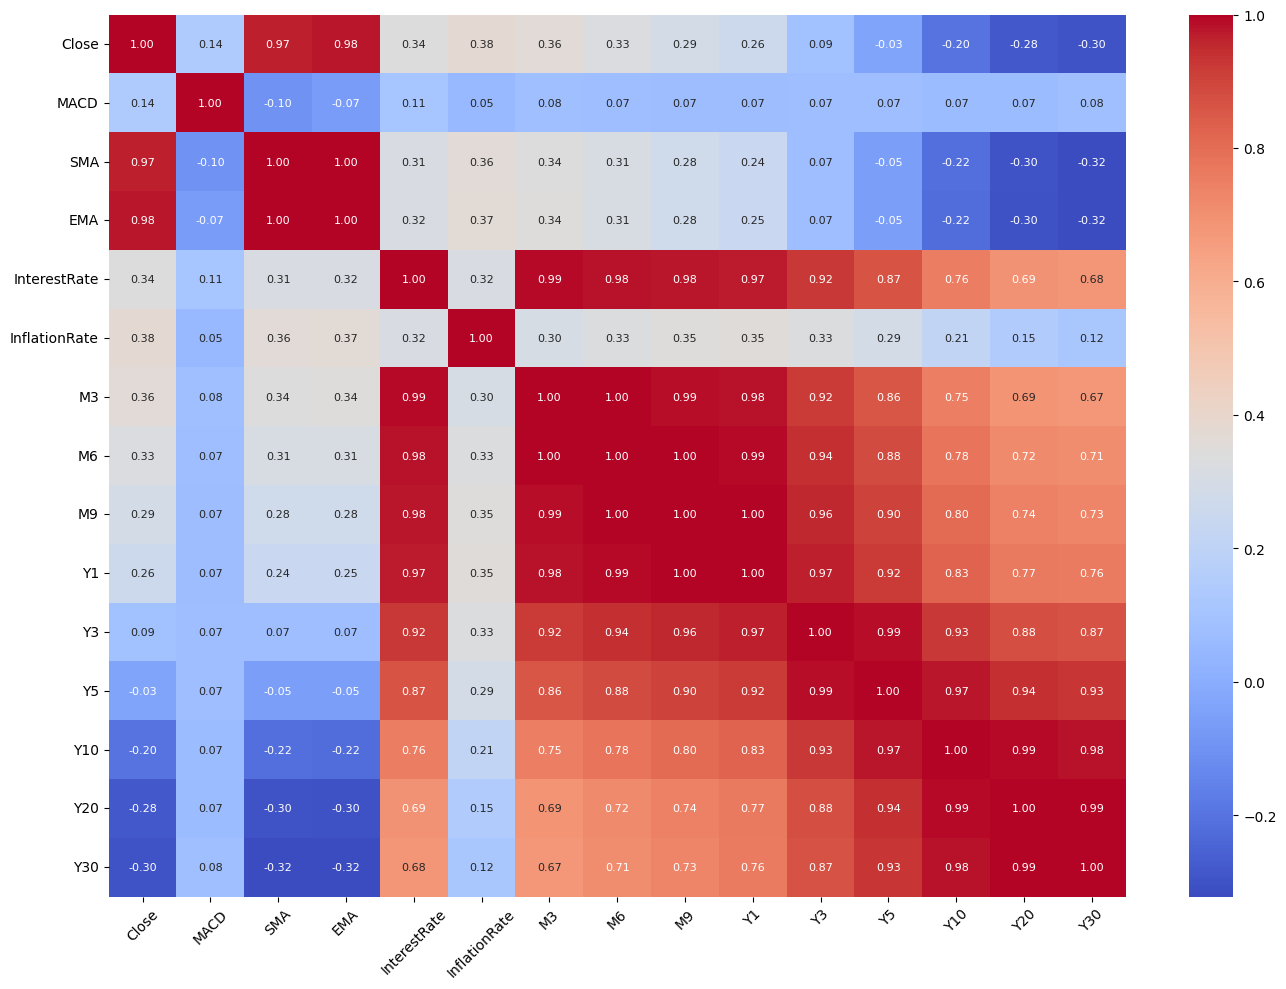

In [38]:
# Convert the Spark DataFrame to a Pandas DataFrame
dataset_knn_pd = dataset_knn.toPandas()

# Exclude non-numeric columns for correlation computation
numeric_dataset = dataset_knn_pd.select_dtypes(include=[float, int])

# Compute the correlation matrix
corr = numeric_dataset.corr()

# Generate a larger heatmap for better readability
plt.figure(figsize=(14, 10)) 
sns.heatmap(corr, 
            xticklabels=corr.columns, 
            yticklabels=corr.columns, 
            annot=True, 
            fmt=".2f",  # Formatting the annotation to two decimal places
            cmap='coolwarm',  # Color map that is easier to read
            annot_kws={"size": 8})  # Adjust annotation font size
plt.xticks(rotation=45)  # Rotate x-axis labels to avoid overlap
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

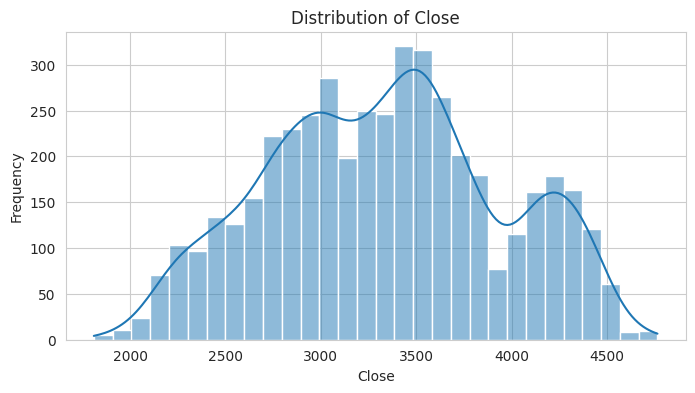

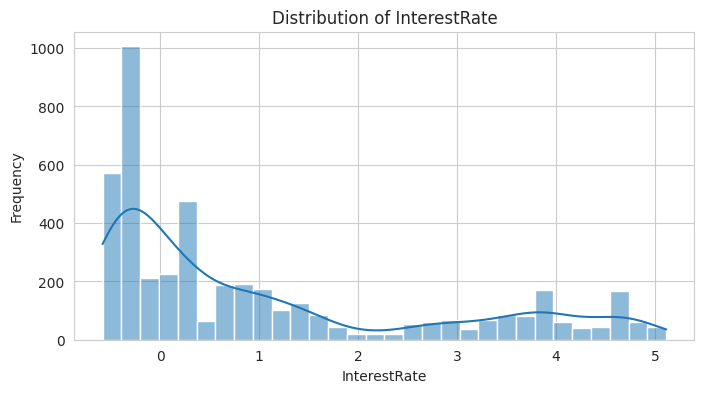

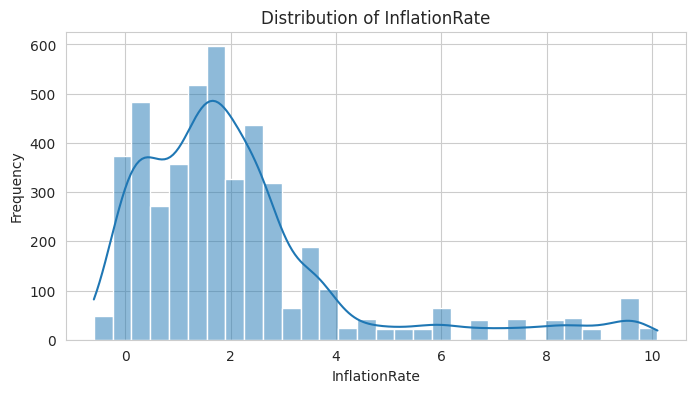

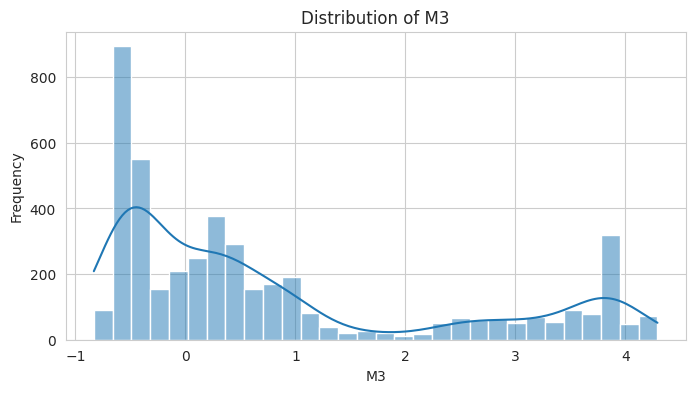

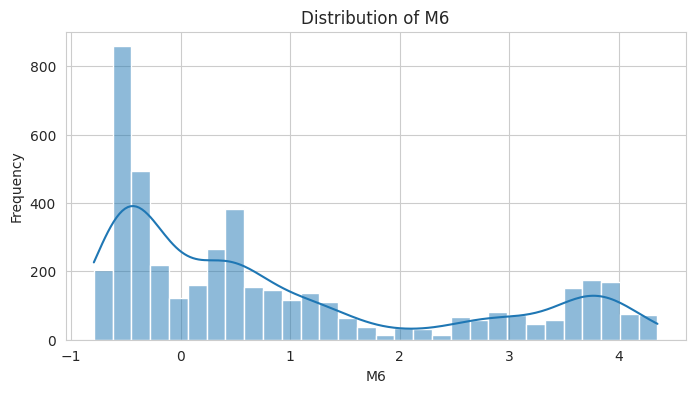

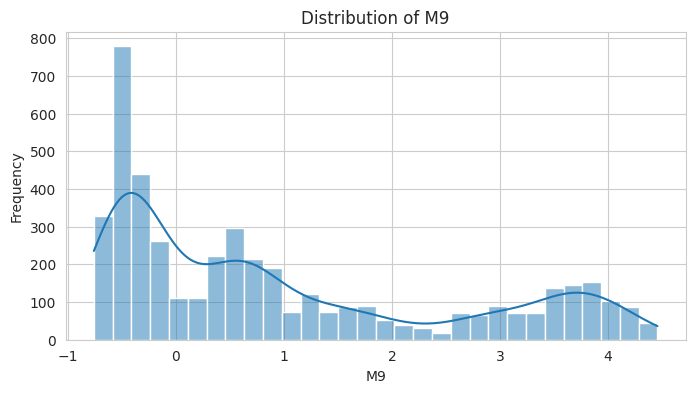

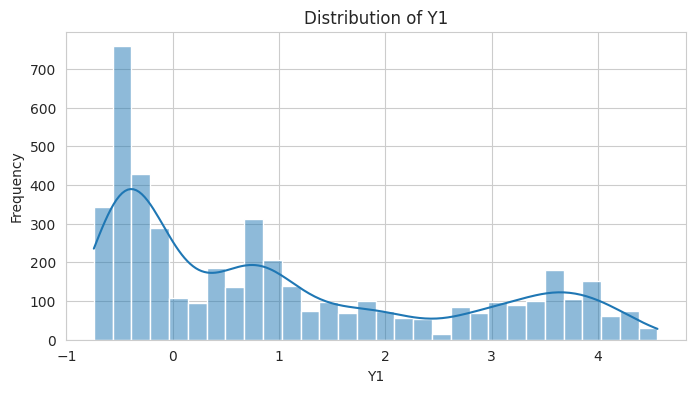

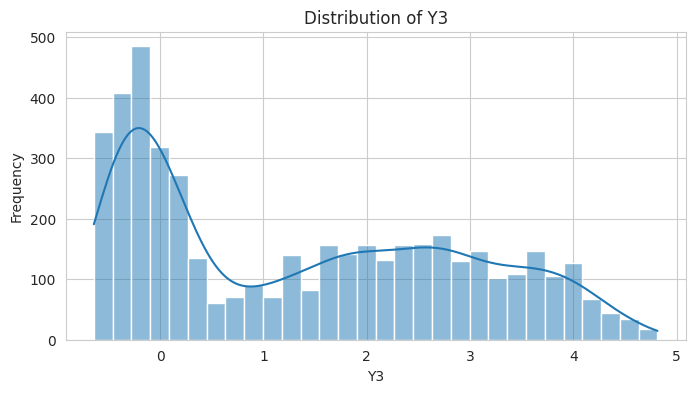

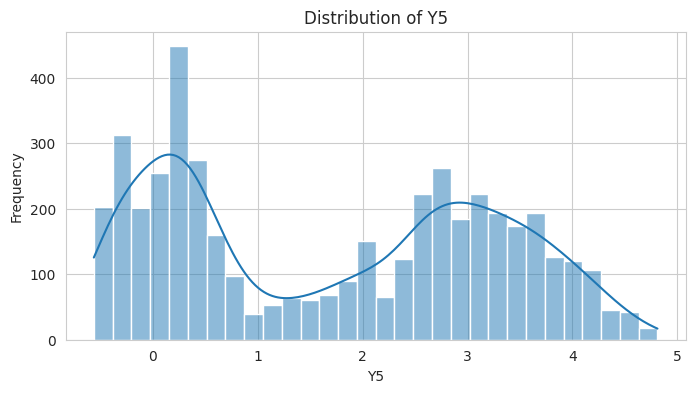

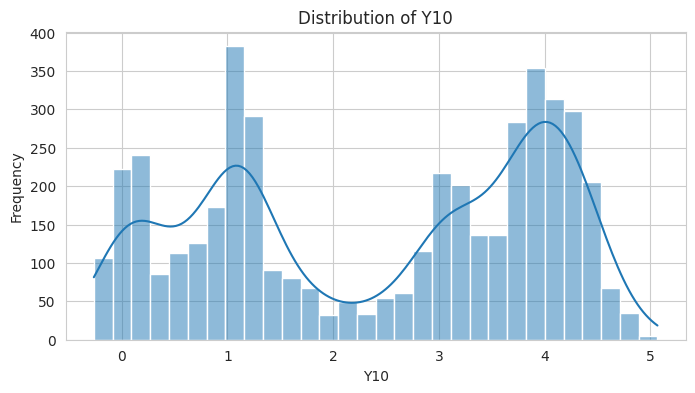

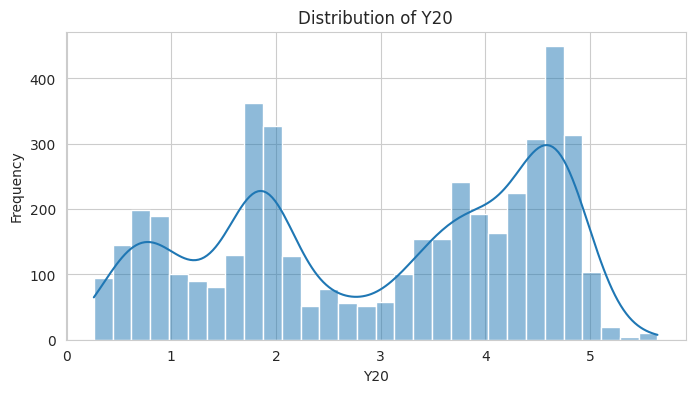

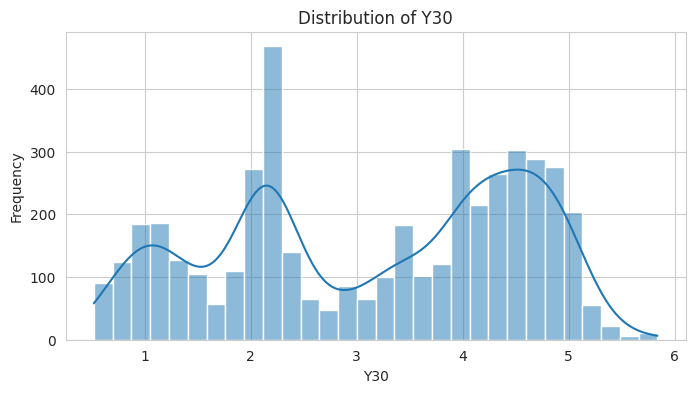

In [39]:
# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# List of key metrics to analyze
metrics = ['Close', 'InterestRate', 'InflationRate', "M3", "M6", "M9", "Y1", "Y3", "Y5", "Y10", "Y20", "Y30"]

# Plotting the distribution for each metric
for metric in metrics:
    plt.figure(figsize=(8, 4))
    sns.histplot(dataset_knn_pd[metric], kde=True, bins=30)
    plt.title(f'Distribution of {metric}')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.show()

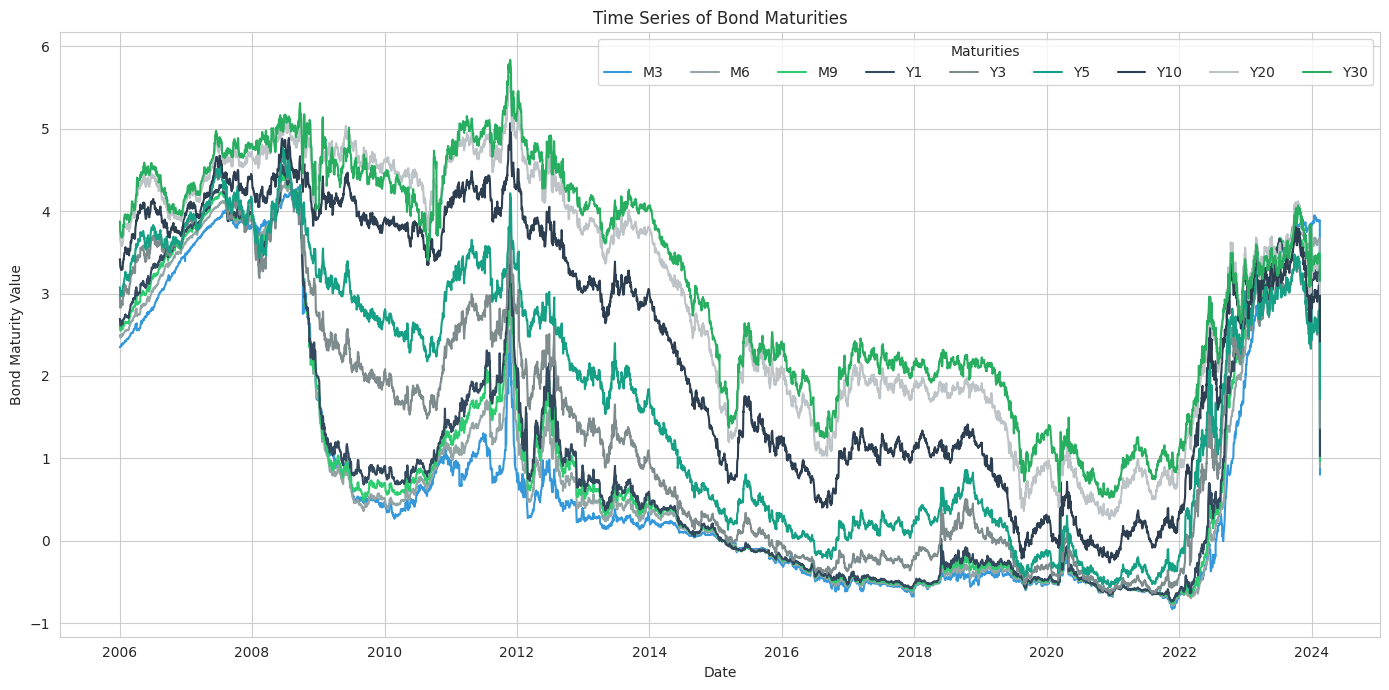

In [40]:
# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Convert date column to datetime
dataset_knn_pd['Date'] = pd.to_datetime(dataset_knn_pd['Date'])

# Define a more neutral color palette
neutral_palette = sns.color_palette(["#3498db", "#95a5a6", "#2ecc71", "#34495e", "#7f8c8d", "#16a085", "#2c3e50", "#bdc3c7", "#27ae60"])

# Plotting the time series for bond maturities in one figure
plt.figure(figsize=(14, 7))
bond_maturities = ["M3", "M6", "M9", "Y1", "Y3", "Y5", "Y10", "Y20", "Y30"]

for i, maturity in enumerate(bond_maturities):
    sns.lineplot(x='Date', y=maturity, data=dataset_knn_pd, label=maturity, color=neutral_palette[i % len(neutral_palette)])

plt.title('Time Series of Bond Maturities')
plt.xlabel('Date')
plt.ylabel('Bond Maturity Value')
plt.legend(title='Maturities', loc='upper right', ncol=9) 
plt.tight_layout() 
plt.show()

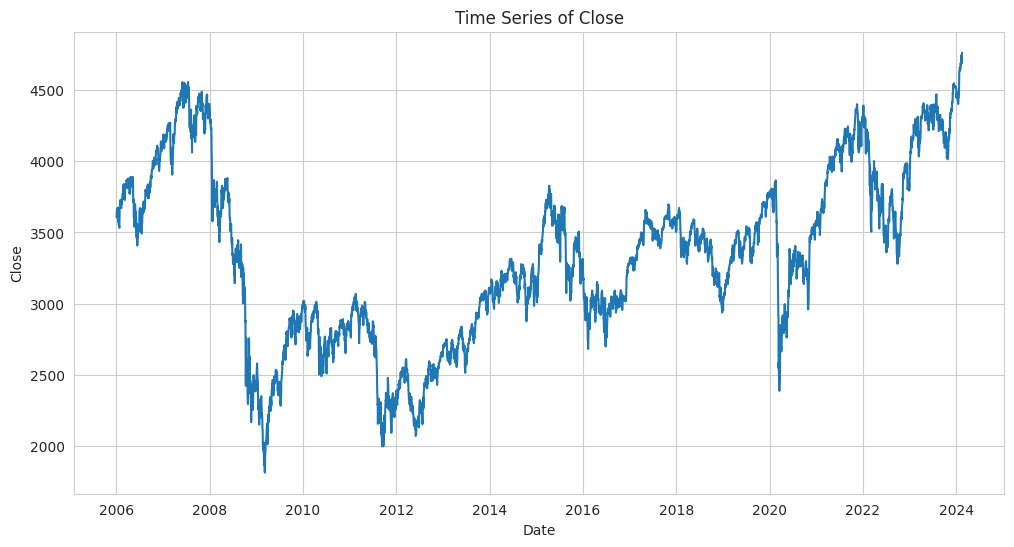

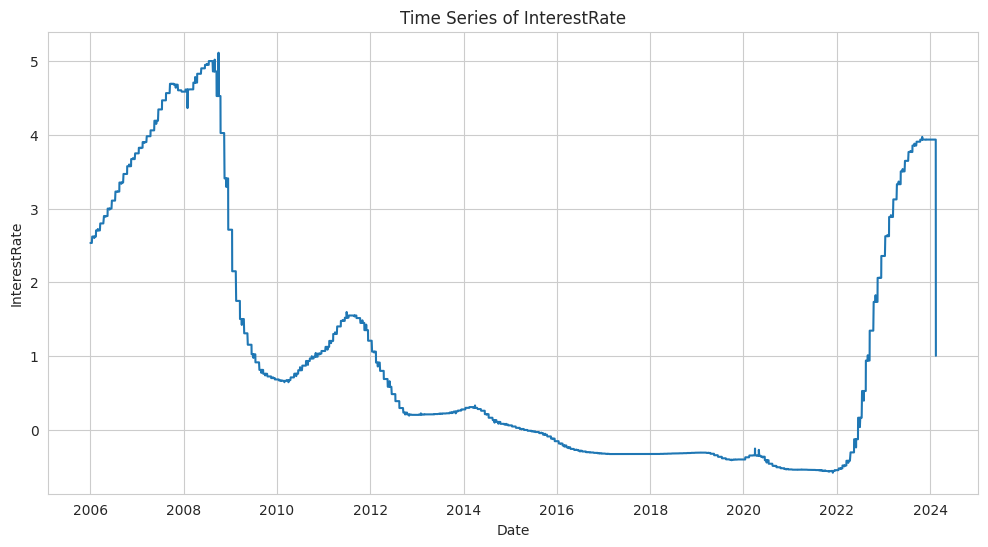

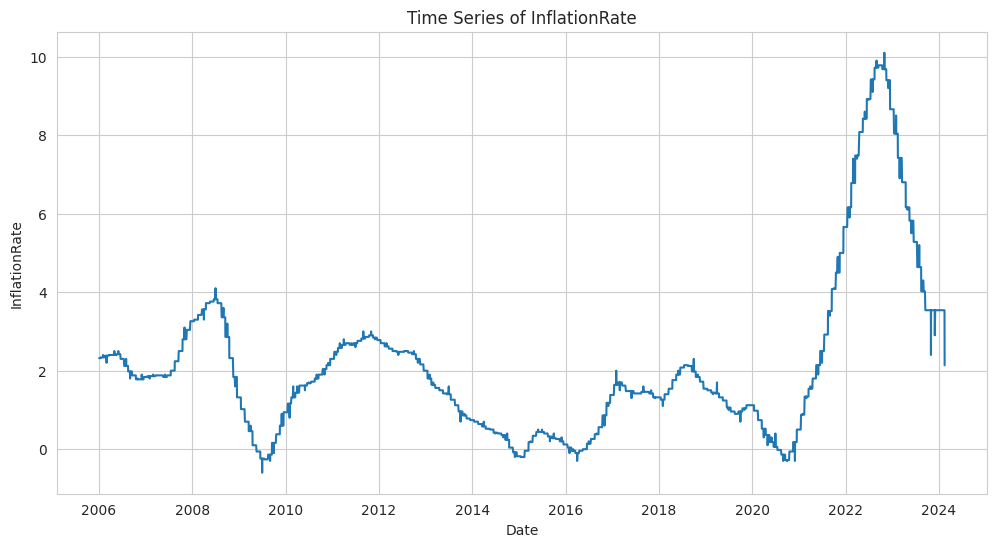

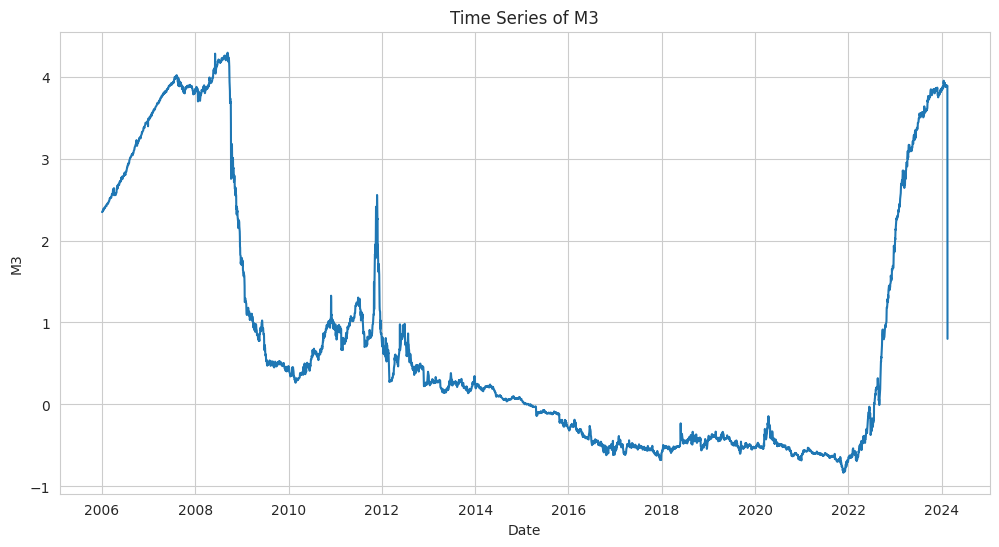

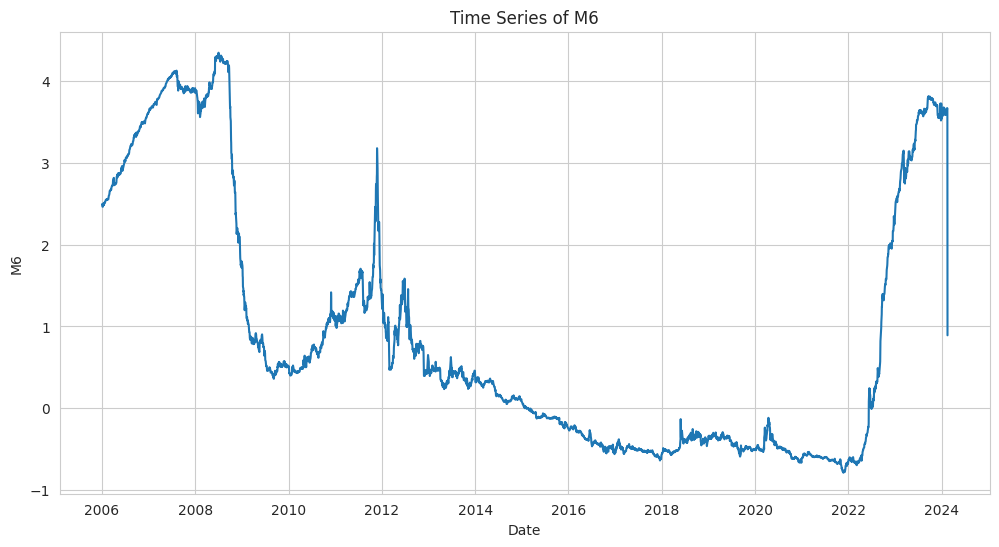

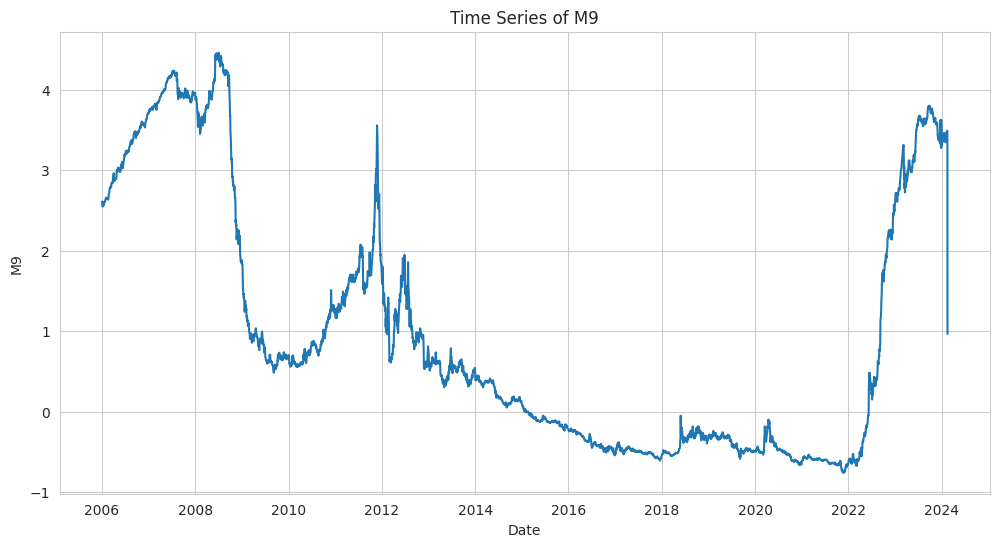

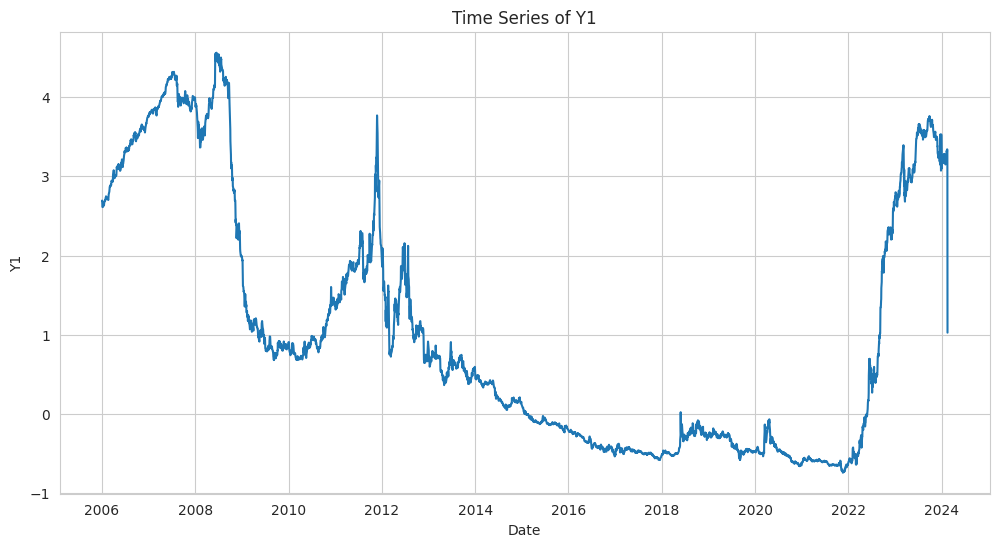

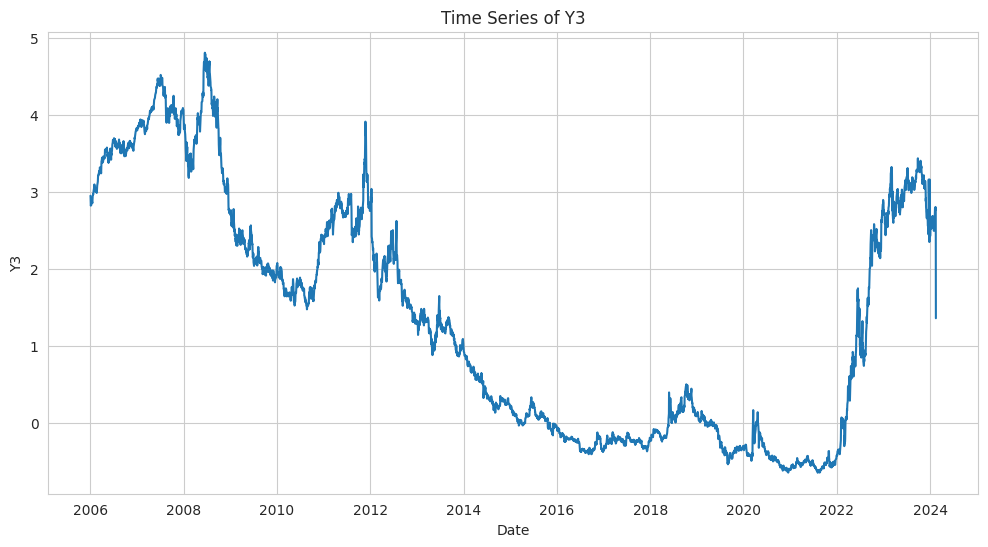

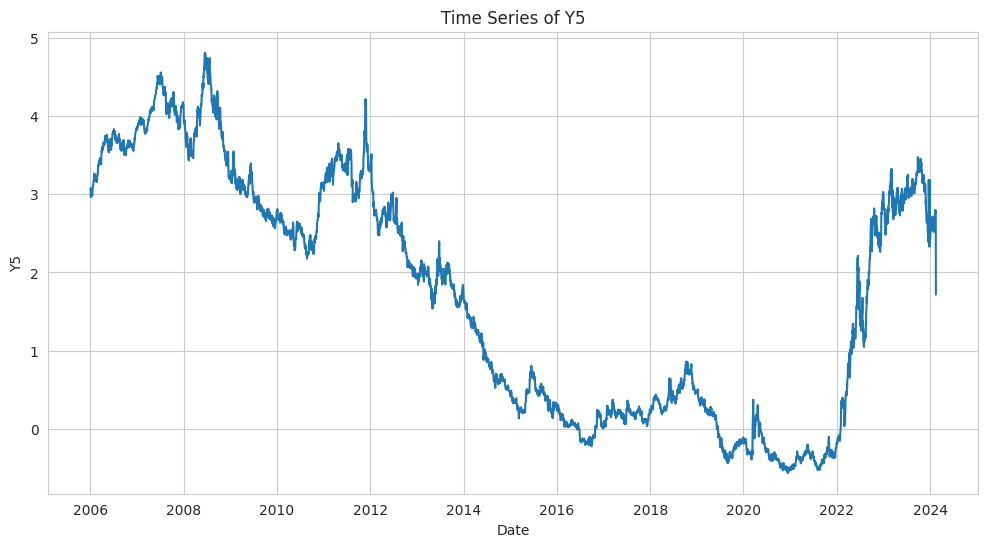

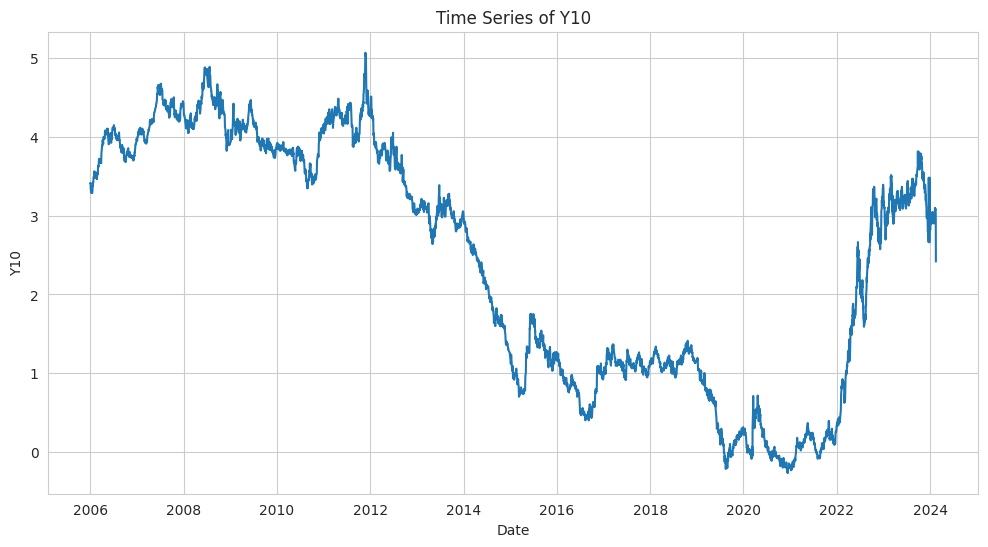

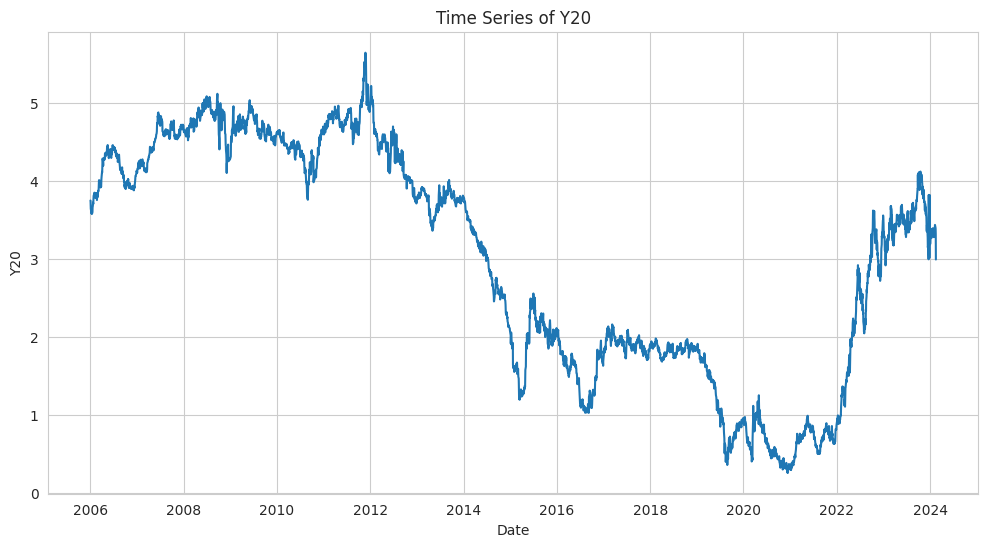

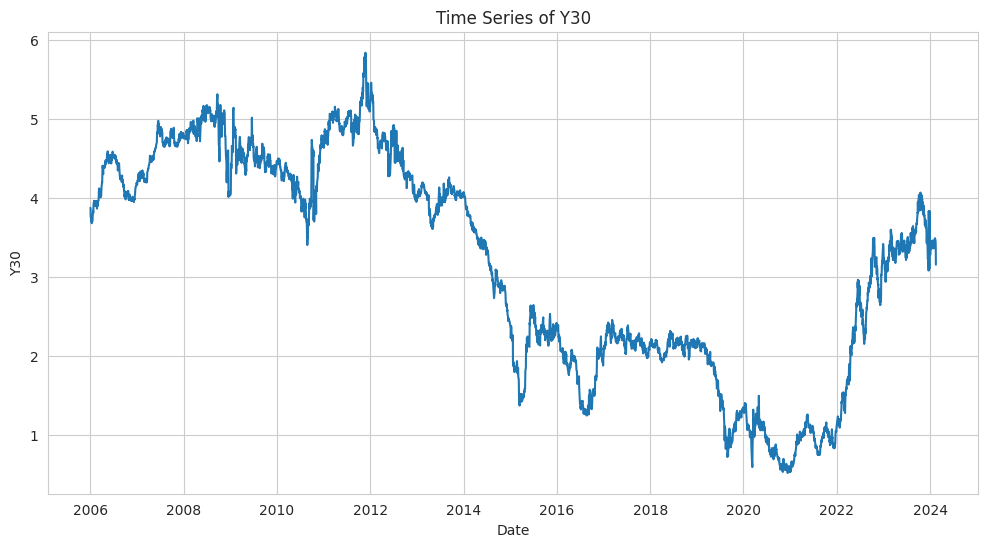

In [41]:
# Plotting time series for each metric
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Date', y=metric, data=dataset_knn_pd)
    plt.title(f'Time Series of {metric}')
    plt.xlabel('Date')
    plt.ylabel(metric)
    plt.show()

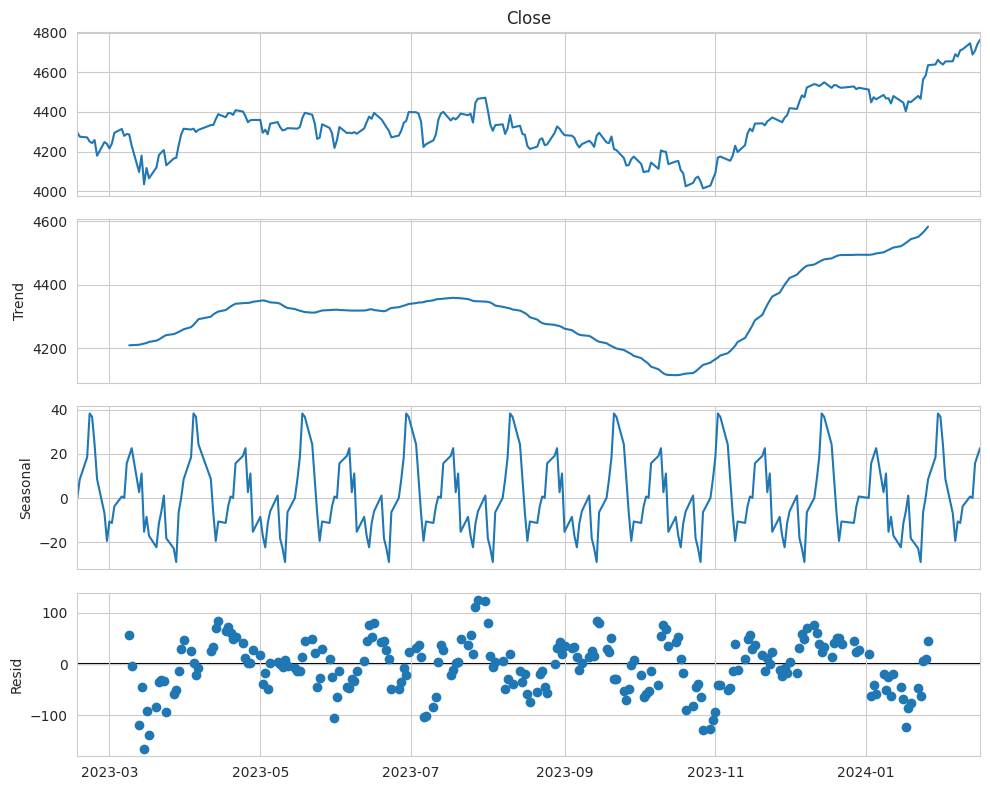

In [42]:
# Convert Spark DataFrame to Pandas DataFrame
dataset_knn_pd = dataset_knn.toPandas()

# Ensure the 'Date' column is in datetime format and set as the index
dataset_knn_pd['Date'] = pd.to_datetime(dataset_knn_pd['Date'])
dataset_knn_pd.set_index('Date', inplace=True)

# Filter for the most recent year, or ensure at least two cycles for the seasonal decompose
max_date = dataset_knn_pd.index.max()
one_year_ago = max_date - pd.DateOffset(years=1)
recent_year_data = dataset_knn_pd[dataset_knn_pd.index >= one_year_ago]

# Select the 'Close' column for analysis
close_series_recent = recent_year_data['Close']

# Perform seasonal decomposition
# Have at least two cycles worth of data, in this case, 60 days for a 30-day period
if len(close_series_recent) >= 60:
    result = seasonal_decompose(close_series_recent, model='additive', period=30)

    # Plot the decomposed components
    fig = result.plot()
    fig.set_size_inches(10, 8)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to perform seasonal decomposition. Need at least 60 observations.")

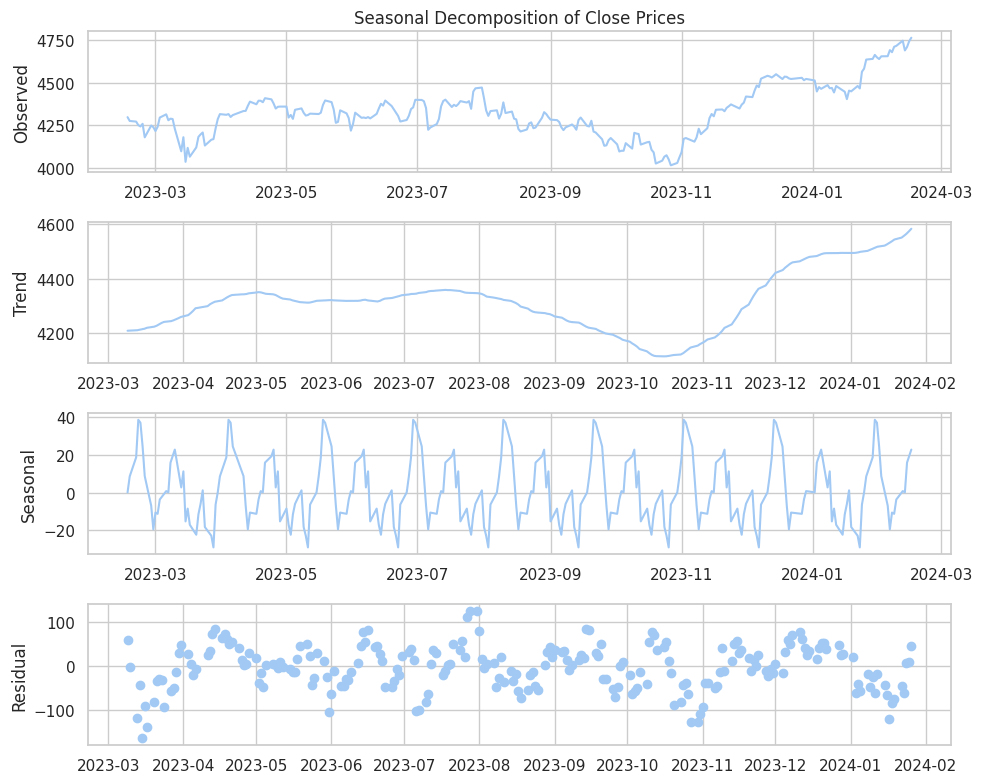

In [43]:
# Load your dataset
dataset_knn_pd = dataset_knn.toPandas()

# Ensure the 'Date' column is in datetime format and set as the index
dataset_knn_pd['Date'] = pd.to_datetime(dataset_knn_pd['Date'])
dataset_knn_pd.set_index('Date', inplace=True)

# Filter for the most recent year, or ensure at least two cycles for the seasonal decompose
max_date = dataset_knn_pd.index.max()
one_year_ago = max_date - pd.DateOffset(years=1)
recent_year_data = dataset_knn_pd[dataset_knn_pd.index >= one_year_ago]

# Select the 'Close' column for analysis
close_series_recent = recent_year_data['Close']

# Perform seasonal decomposition
# Have at least two cycles worth of data, in this case, 60 days for a 30-day period
if len(close_series_recent) >= 60:
    result = seasonal_decompose(close_series_recent, model='additive', period=30)

    # Set style for the plots
    sns.set(style="whitegrid", palette="pastel", color_codes=True)

    # Plot the decomposed components
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
    
    ax1.plot(result.observed)
    ax1.set_ylabel('Observed')
    ax1.set_title('Seasonal Decomposition of Close Prices')

    ax2.plot(result.trend)
    ax2.set_ylabel('Trend')

    ax3.plot(result.seasonal)
    ax3.set_ylabel('Seasonal')

    ax4.scatter(recent_year_data.index, result.resid)
    ax4.set_ylabel('Residual')
    
    # Optional
    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to perform seasonal decomposition. Need at least 60 observations.")

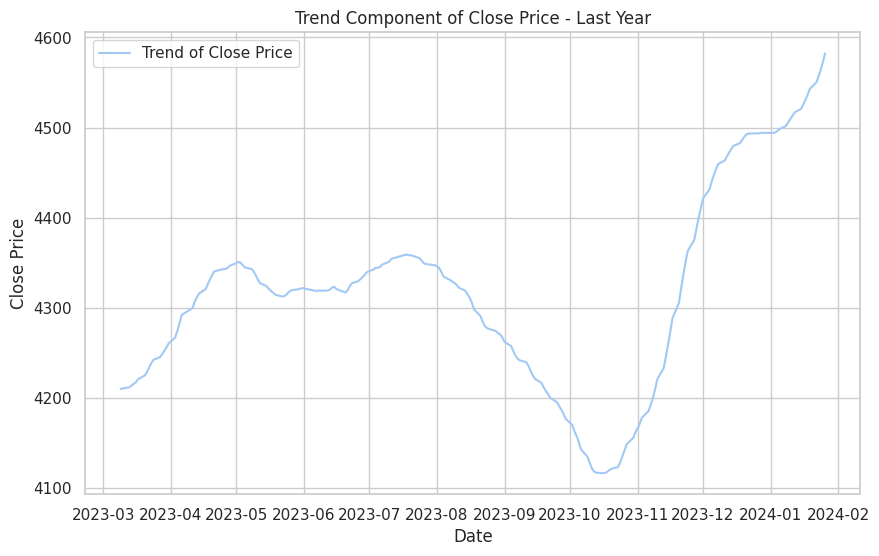

In [44]:
# Convert Spark DataFrame to Pandas DataFrame
dataset_knn_pd = dataset_knn.toPandas()

# Make sure the 'Date' column is in datetime format and set as the index
dataset_knn_pd['Date'] = pd.to_datetime(dataset_knn_pd['Date'])
dataset_knn_pd.set_index('Date', inplace=True)

# Filter for the most recent year
max_date = dataset_knn_pd.index.max()
one_year_ago = max_date - pd.DateOffset(years=1)
recent_year_data = dataset_knn_pd[dataset_knn_pd.index >= one_year_ago]

# Select the 'Close' column
close_series_recent = recent_year_data['Close']

# Decompose to extract the trend component
decomposition = seasonal_decompose(close_series_recent, model='additive', period=30)
trend = decomposition.trend

# Plotting the trend
plt.figure(figsize=(10, 6))
plt.plot(trend, label='Trend of Close Price')
plt.title('Trend Component of Close Price - Last Year')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

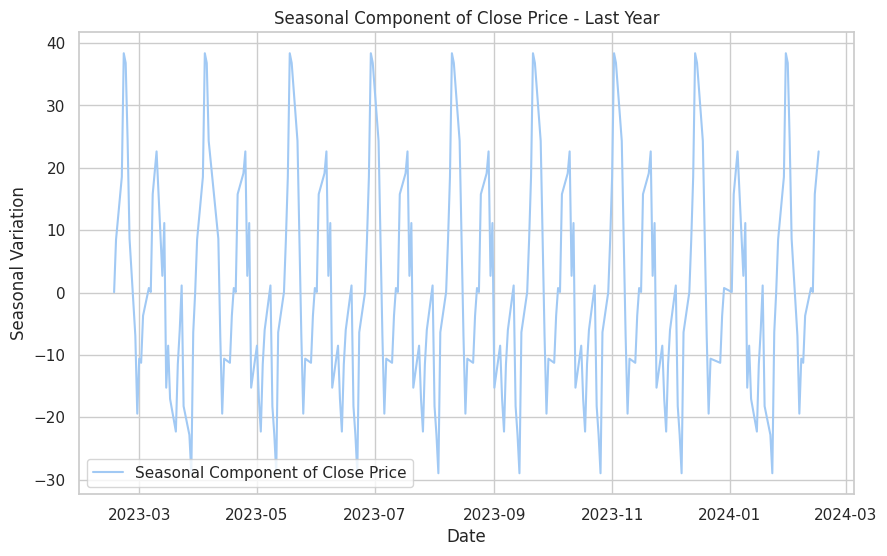

In [45]:
# Plotting the seasonal component
seasonal_component = decomposition.seasonal

plt.figure(figsize=(10, 6))
plt.plot(seasonal_component, label='Seasonal Component of Close Price')
plt.title('Seasonal Component of Close Price - Last Year')
plt.xlabel('Date')
plt.ylabel('Seasonal Variation')
plt.legend()
plt.show()

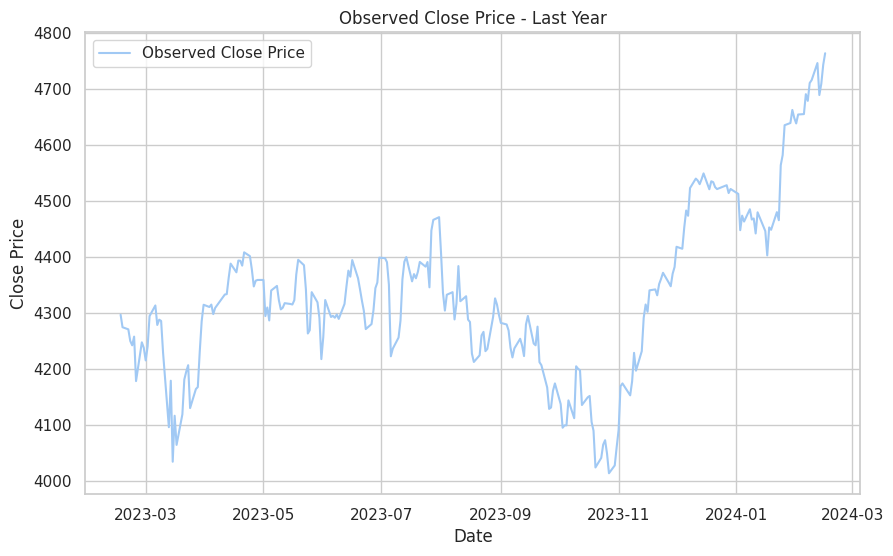

In [46]:
# Plotting the observed data
observed_component = decomposition.observed

plt.figure(figsize=(10, 6))
plt.plot(observed_component, label='Observed Close Price')
plt.title('Observed Close Price - Last Year')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

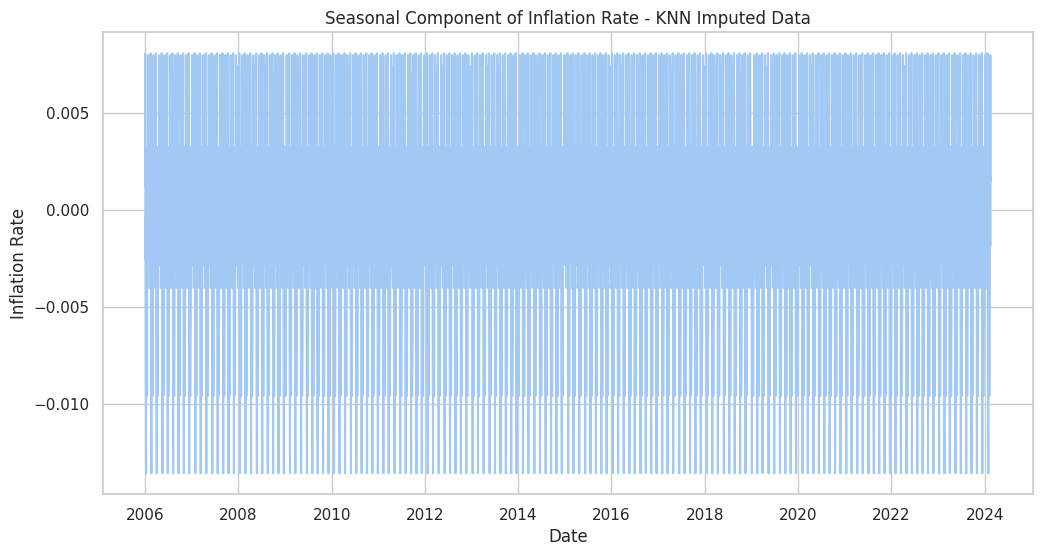

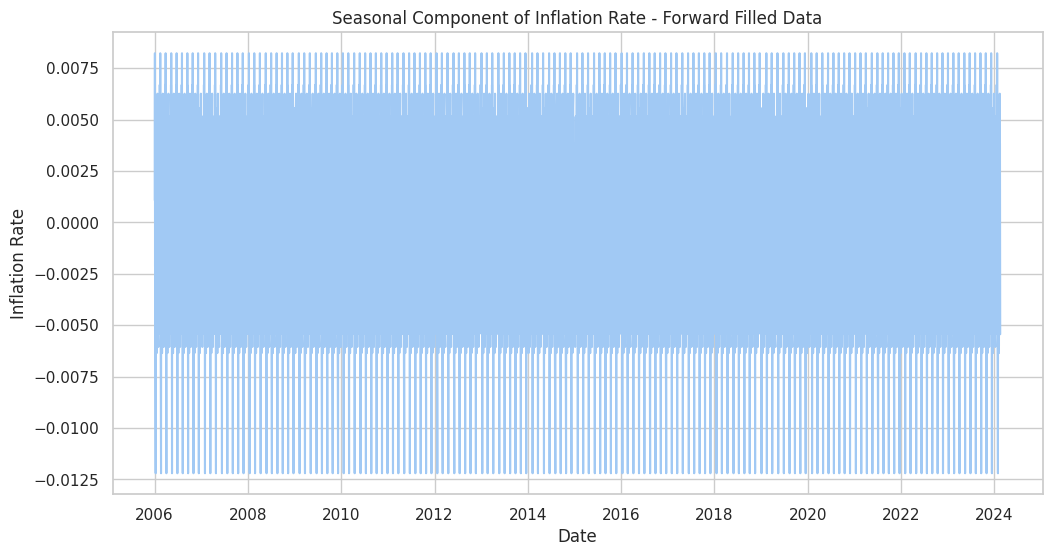

In [47]:
def create_seasonal_plot(dataframe, title):
    # Check if 'Date' column exists, and if so, convert it to datetime and set as index
    if 'Date' in dataframe.columns:
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        dataframe.set_index('Date', inplace=True)

    # Decompose to extract the seasonal component
    result = seasonal_decompose(dataframe['InflationRate'], model='additive', period=30)
    
    # Plotting the seasonal component
    plt.figure(figsize=(12, 6))
    plt.plot(result.seasonal)
    plt.title(f'Seasonal Component of Inflation Rate - {title}')
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate')
    plt.show()

# Create seasonal plots
create_seasonal_plot(dataset_knn_pd, "KNN Imputed Data")
create_seasonal_plot(dataset_ff_pd, "Forward Filled Data")

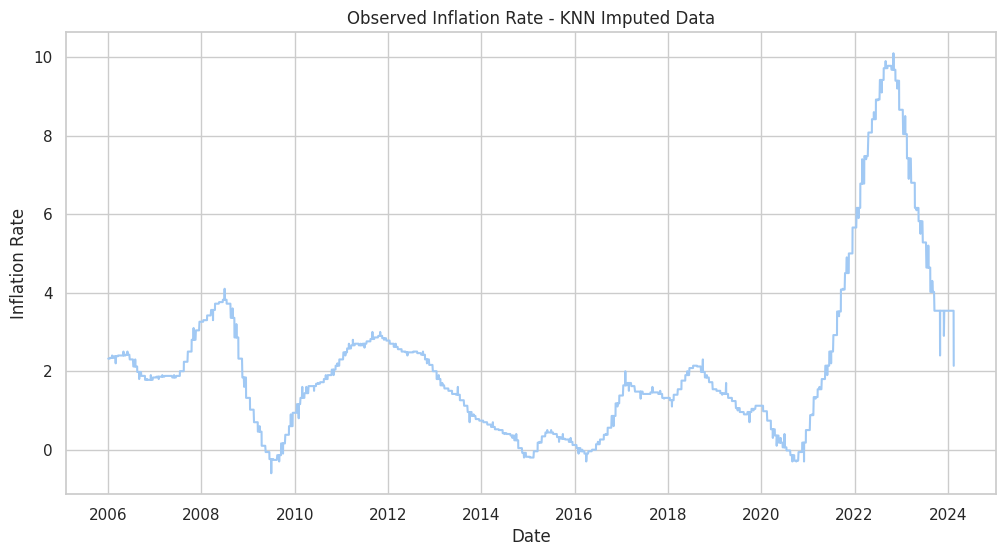

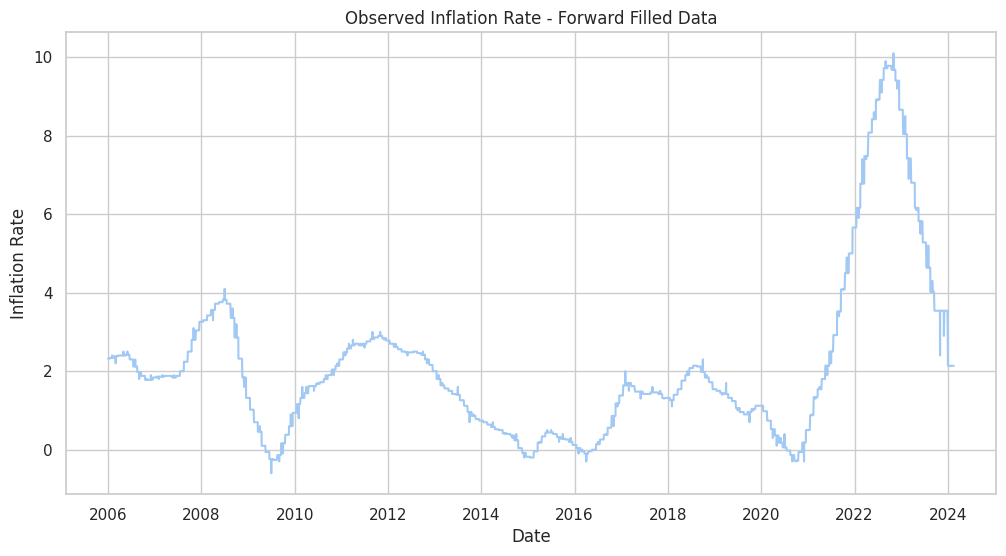

In [48]:
def create_observed_plot(dataframe, title):
    # Check if 'Date' column exists, and if so, convert it to datetime and set as index
    if 'Date' in dataframe.columns:
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        dataframe.set_index('Date', inplace=True)

    # Decompose to extract the observed component
    result = seasonal_decompose(dataframe['InflationRate'], model='additive', period=365)
    
    # Plotting the observed component
    plt.figure(figsize=(12, 6))
    plt.plot(result.observed)
    plt.title(f'Observed Inflation Rate - {title}')
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate')
    plt.show()

# Create observed plots
create_observed_plot(dataset_knn_pd, "KNN Imputed Data")
create_observed_plot(dataset_ff_pd, "Forward Filled Data")

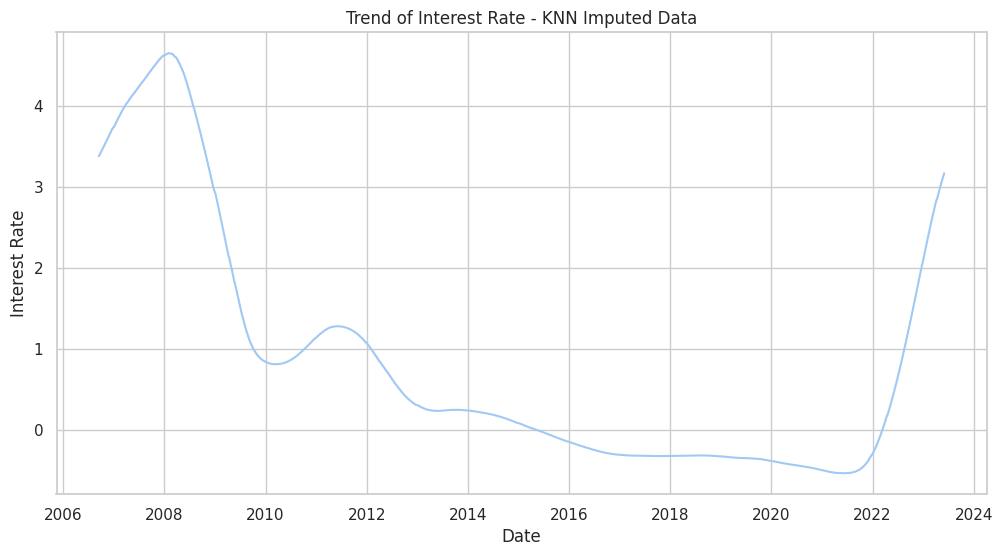

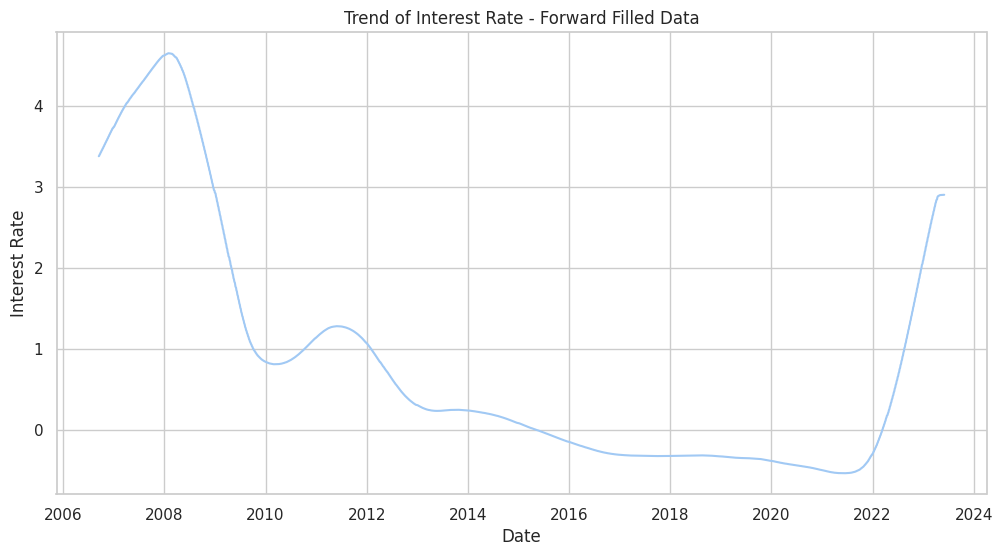

In [49]:
def create_trend_plot_interest(dataframe, title):
    if 'Date' in dataframe.columns:
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        dataframe.set_index('Date', inplace=True)

    result = seasonal_decompose(dataframe['InterestRate'], model='additive', period=365)
    plt.figure(figsize=(12, 6))
    plt.plot(result.trend)
    plt.title(f'Trend of Interest Rate - {title}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate')
    plt.show()

create_trend_plot_interest(dataset_knn_pd, "KNN Imputed Data")
create_trend_plot_interest(dataset_ff_pd, "Forward Filled Data")

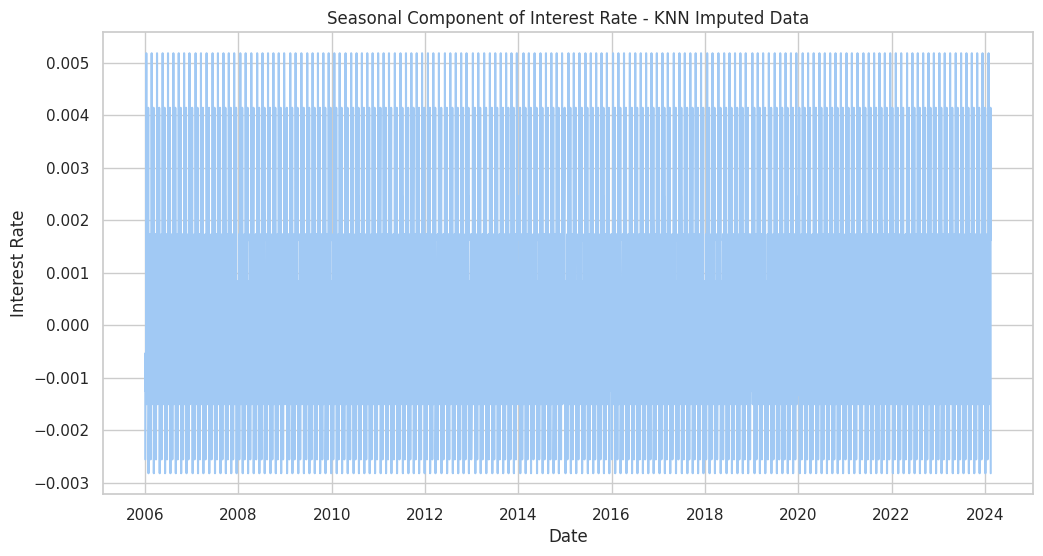

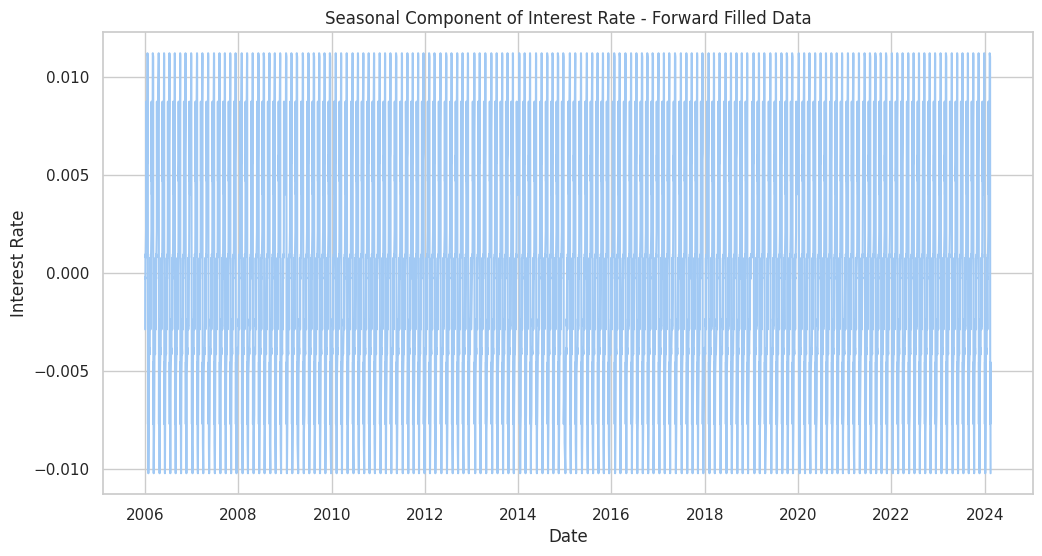

In [50]:
def create_seasonal_plot_interest(dataframe, title):
    if 'Date' in dataframe.columns:
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        dataframe.set_index('Date', inplace=True)

    result = seasonal_decompose(dataframe['InterestRate'], model='additive', period=30)
    plt.figure(figsize=(12, 6))
    plt.plot(result.seasonal)
    plt.title(f'Seasonal Component of Interest Rate - {title}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate')
    plt.show()

create_seasonal_plot_interest(dataset_knn_pd, "KNN Imputed Data")
create_seasonal_plot_interest(dataset_ff_pd, "Forward Filled Data")

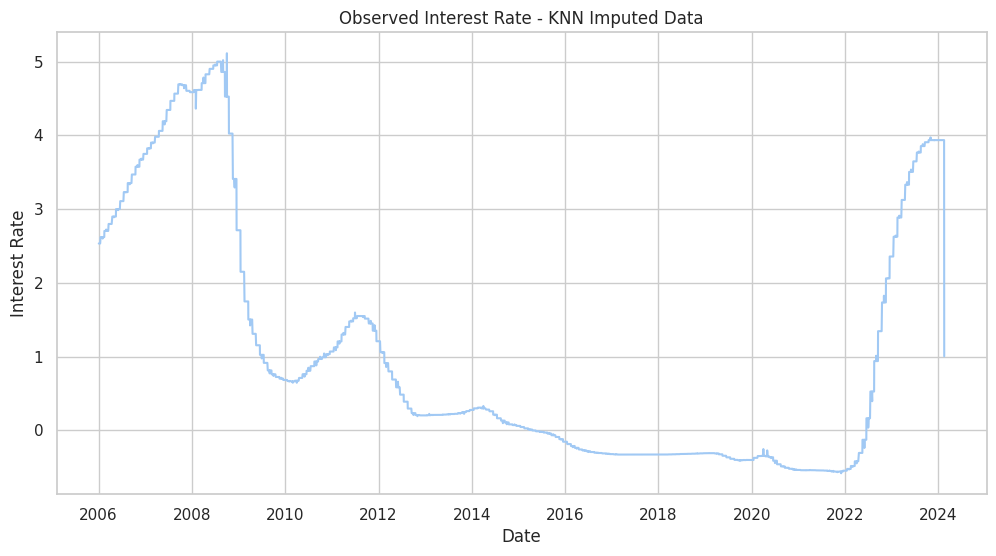

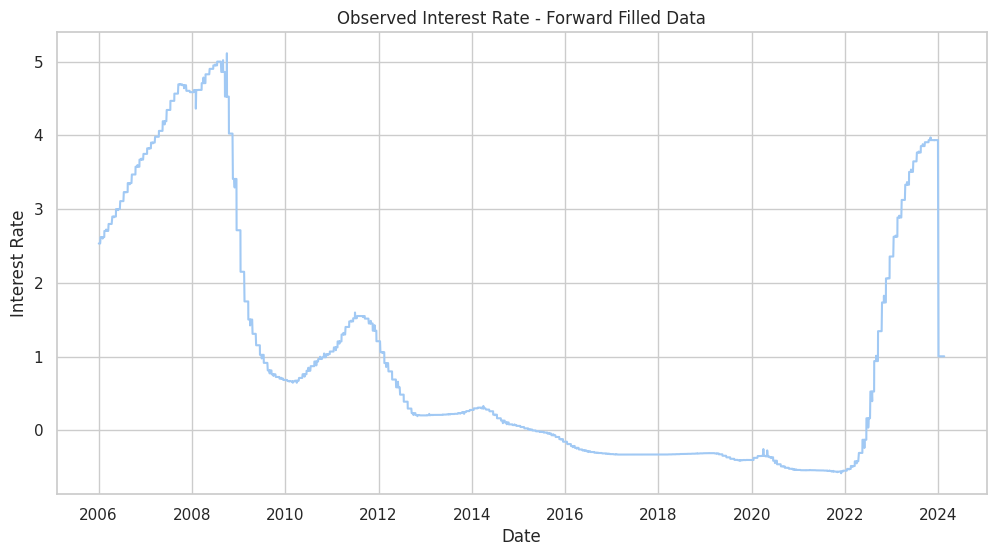

In [51]:
def create_observed_plot_interest(dataframe, title):
    if 'Date' in dataframe.columns:
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        dataframe.set_index('Date', inplace=True)

    result = seasonal_decompose(dataframe['InterestRate'], model='additive', period=365)
    plt.figure(figsize=(12, 6))
    plt.plot(result.observed)
    plt.title(f'Observed Interest Rate - {title}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate')
    plt.show()

create_observed_plot_interest(dataset_knn_pd, "KNN Imputed Data")
create_observed_plot_interest(dataset_ff_pd, "Forward Filled Data")